# COVID-19 en Colombia

In [1]:
%pip install sodapy
%pip install statsmodels==0.12.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
from sodapy import Socrata
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib
from matplotlib.dates import DateFormatter

%matplotlib inline

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from itertools import product

from scipy.integrate import odeint
from scipy.optimize import minimize
import pylab as pl
from copy import copy

from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

pd.options.display.max_columns = 50
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 5]
formatter = DateFormatter('%d %b %Y')

## Descarga de Información
La descarga de la información se descarga usando la librería Socrata, la misma permite descargar la información más recuente. No obstante, si esta falla se lee una copia local de la información.

In [3]:
try:
    socrata_domain = "www.datos.gov.co"
    socrata_dataset_identifier = "gt2j-8ykr"

    client = Socrata(socrata_domain, None)
    results = client.get(socrata_dataset_identifier,limit=1000000000)
    
    df = pd.DataFrame.from_dict(results)
    df.to_csv('./spreadsheets/data_covid.csv', index=False)
    
    
    socrata_dataset_identifier = "8835-5baf"
    results = client.get(socrata_dataset_identifier,limit=1000000000)
    
    df_pruebas = pd.DataFrame.from_dict(results)
    df_pruebas.to_csv('./spreadsheets/pruebas_covid.csv', index=False)
    
except:
    df = pd.read_csv('./spreadsheets/data_covid.csv')
    df_pruebas = pd.read_csv('./spreadsheets/pruebas_covid.csv')
    
poblacion_ciudades = pd.read_csv('./spreadsheets/top20ciudades.csv')

/home/dogeubuntu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Estandarización de las columnas

Se cambian los valores nulos por el correspondiente valor en **numpy**.

In [4]:
df.fillna(value=np.NaN, inplace=True)

Se castean las columnas que contienen fechas.

In [5]:
date_columns = ['fecha_de_muerte',
                'fecha_recuperado', 
                'fecha_reporte_web',
                'fecha_diagnostico',
                'fecha_de_notificaci_n']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])

Se castean variables que corresponden estrictamente a enteros.

In [6]:
df['edad'] = df['edad'].apply(lambda x: int(x))

Se eliminan diferencias en columnas que contoenen cadenas de caracteres con el fin de eliminar cualquier diferencia dado el uso de capitalización, mayúsculas y minúsculas.

In [7]:
cat_cols = ['sexo', 'tipo', 'estado', 'atenci_n', 'pertenencia_etnica', 'tipo_recuperaci_n']

for col in cat_cols:
    df[col] = df[col].apply(lambda x: str(x).strip().capitalize() if str(x) != 'N/A' else str(x).strip())

Se corrige el primer valor reportado de pruebas realizadas en el mes de Febrero y se le asigna el último día del mismo mes.

In [8]:
df_pruebas.replace("Acumulado Feb", value="2020-02-29T00:00:00.000", inplace = True)
df_pruebas['fecha'] = pd.to_datetime(df_pruebas['fecha'])
df_pruebas['acumuladas']= df_pruebas['acumuladas'].astype('int')

## Exploración

In [9]:
df.head(2)

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,Pcr,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,Pcr,76,724.0,Otro,NaN,NaT


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666521 entries, 0 to 666520
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id_de_caso             666521 non-null  int64         
 1   fecha_de_notificaci_n  666521 non-null  datetime64[ns]
 2   c_digo_divipola        666521 non-null  int64         
 3   ciudad_de_ubicaci_n    666521 non-null  object        
 4   departamento           666521 non-null  object        
 5   atenci_n               666521 non-null  object        
 6   edad                   666521 non-null  int64         
 7   sexo                   666521 non-null  object        
 8   tipo                   666521 non-null  object        
 9   estado                 666521 non-null  object        
 10  pa_s_de_procedencia    965 non-null     object        
 11  fis                    666521 non-null  object        
 12  fecha_diagnostico      662525 non-null  date

Se encuentra que la única columna que data de fechas con valores no nulos corresponde a`fecha_reporte_web` y se decide ordenar los datos de acuerdo a esta variable. La columna `fis` a pesar de corresponder a una variable con fechas contiene inconsistencias, por lo tanto no se tendrá en cuenta.

In [11]:
df = df.sort_values(by='fecha_reporte_web')

In [12]:
df.describe(include='all')

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
count,666521.000000,666521,666521.000000,666521,666521,666521,666521.000000,666521,666521,666521,965,666521,662525,518234,666521,666521,666521.000000,961.000000,666521,11325,22784
unique,NaN,186,NaN,957,37,6,NaN,2,3,6,50,632,183,176,182,3,NaN,NaN,5,1289,170
top,NaN,2020-07-27 00:00:00,NaN,Bogotá D.C.,Bogotá D.C.,Recuperado,NaN,M,En estudio,Leve,ESPAÑA,Asintomático,2020-08-11 00:00:00,2020-08-23 00:00:00,2020-08-19 00:00:00,Tiempo,NaN,NaN,Nan,Sin Comunidad,2020-07-30 00:00:00
freq,NaN,12112,NaN,225947,225947,518229,NaN,341444,633630,539825,265,81000,17460,14150,13056,419965,NaN,NaN,383066,2829,377
first,NaN,2020-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-06 00:00:00,2020-03-13 00:00:00,2020-03-06 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-03-16 00:00:00
last,NaN,2020-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-06 00:00:00,2020-09-06 00:00:00,2020-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,2020-09-06 00:00:00
mean,333300.737225,NaN,25664.589467,NaN,NaN,NaN,39.666717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.546826,594.686785,NaN,NaN,NaN
std,192408.635893,NaN,24857.333435,NaN,NaN,NaN,18.141266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.839817,257.360777,NaN,NaN,NaN
min,1.000000,NaN,5001.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,32.000000,NaN,NaN,NaN
25%,166671.000000,NaN,11001.000000,NaN,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,388.000000,NaN,NaN,NaN


Se chequean los valores nulos en el dataset, respecto al total de récords en el mismo, a fin de expresar estos como porcentaje.

In [13]:
df.isna().sum()[df.isna().sum()>0].to_frame('Nulls') / len(df)*100

,Nulls
pa_s_de_procedencia,99.855218
fecha_diagnostico,0.599531
fecha_recuperado,22.247911
codigo_pais,99.855818
nombre_grupo_etnico,98.300879
fecha_de_muerte,96.581653


La columna `pa_s_de_procedencia` y `codigo_pais` cuentan con un significativo porcentaje de nulos ya que los casos que se dan entre personas que no contrajeron el virus en el exterior no cuentan con un valor. Por otro lado, la columna `fecha_de_muerte` cuenta con un alto porcentaje de nulos dada la baja mortalidad del virus. Finalmente, las columnas `pertenencia_etnica` y `nombre_grupo_etnica` cuentan con valores nulos dado el desconocimiento de dicha clasificación por parte de los pacientes.

Antes de continuar con el análisis se decidió prescindir de aquellas columnas que no agregan información.

In [14]:
to_drop = ['id_de_caso', 'fis', 'c_digo_divipola', 'codigo_departamento','codigo_pais']

df.drop(labels=to_drop, axis=1, inplace=True)

In [15]:
df.head()

,fecha_de_notificaci_n,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,2020-03-02,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-03-06,2020-03-13,2020-03-06,Pcr,Otro,NaN,NaT
1,2020-03-06,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-09,2020-03-19,2020-03-09,Pcr,Otro,NaN,NaT
2,2020-03-07,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-03-09,2020-03-15,2020-03-09,Pcr,Otro,NaN,NaT
3,2020-03-09,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-11,2020-03-26,2020-03-11,Pcr,Otro,NaN,NaT
4,2020-03-09,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-11,2020-03-23,2020-03-11,Pcr,Otro,NaN,NaT


# Análisis de los Datos

Se analizan las variables categóricas y numéricas las cuales permitieron entender la distribución del virus en distintos niveles:
- Nivel País
- Nivel Ciudad (Top 5 ciudades con más casos)

## Nivel País

El análisis comienza por un chequeo de la evolución del virus día a día.

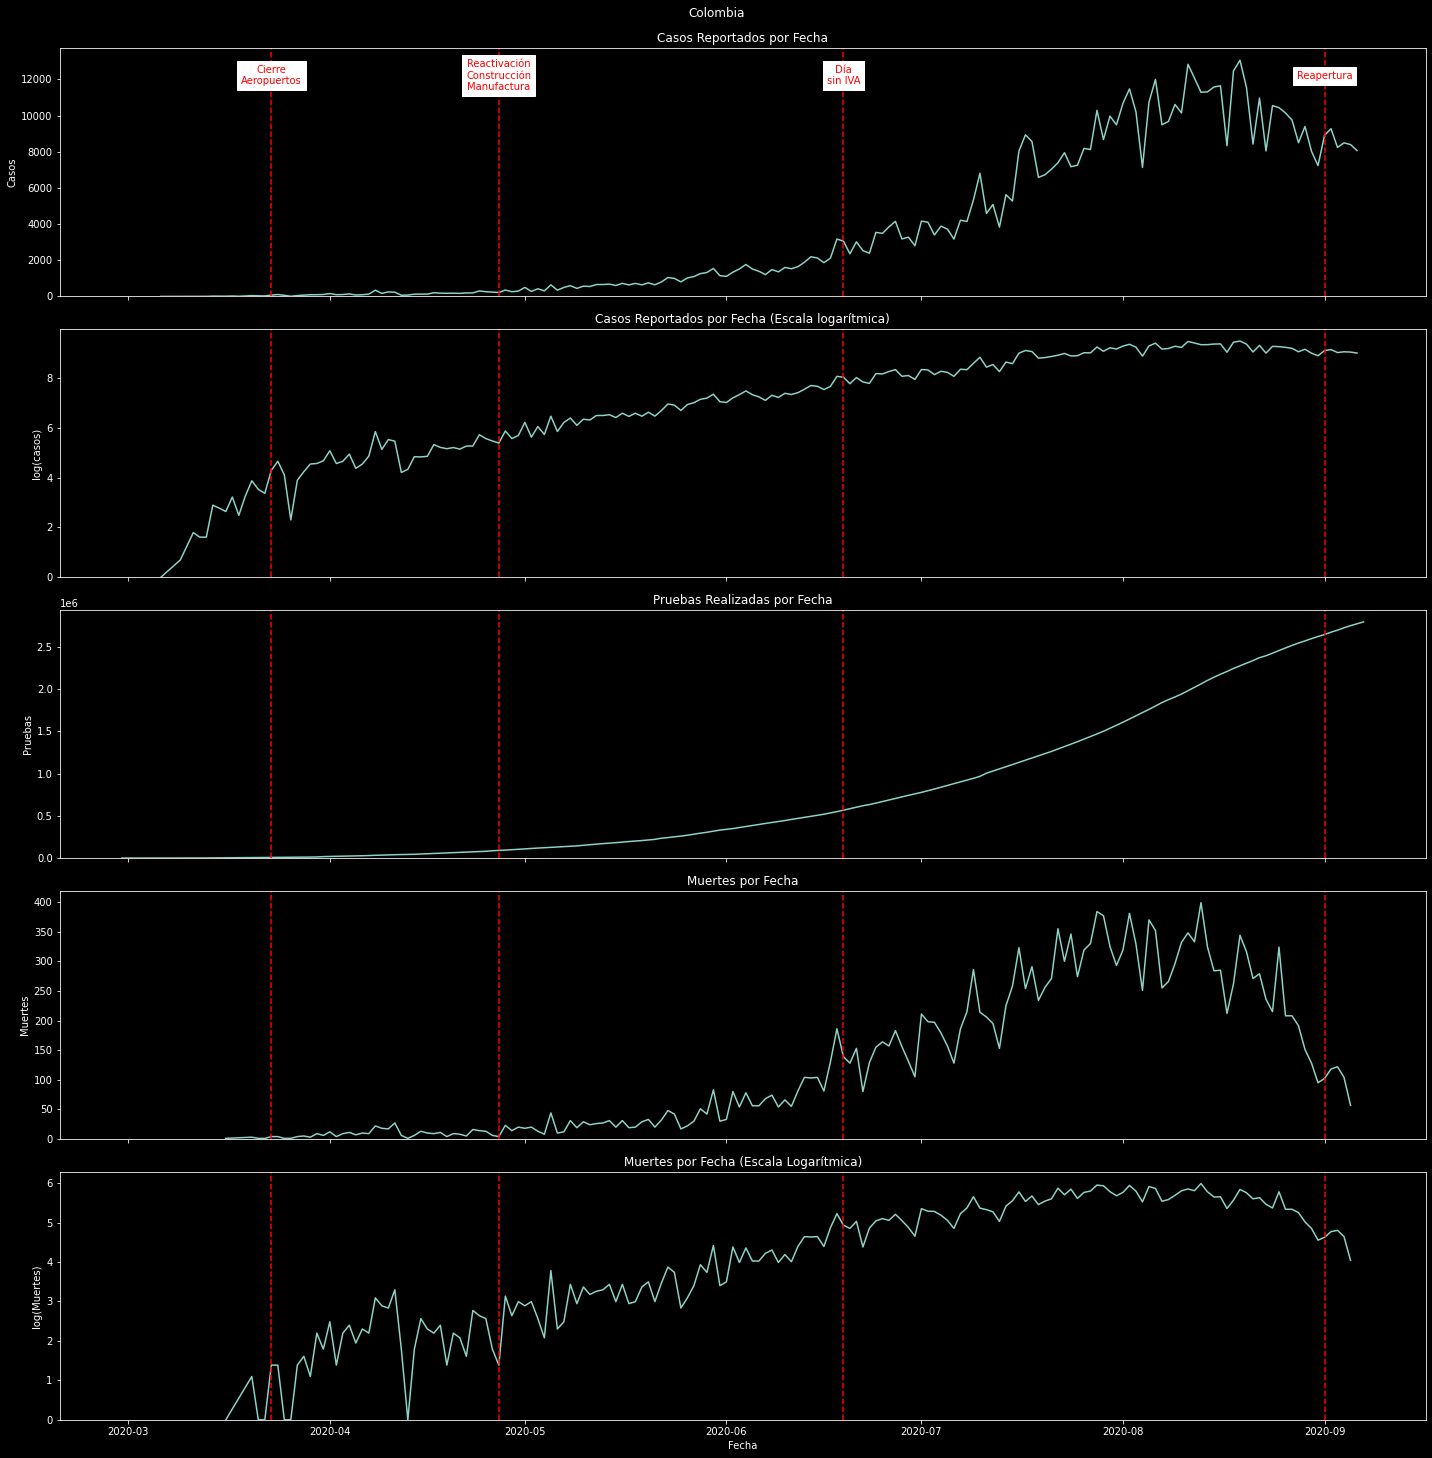

In [16]:
#Se agrupa el total de infecciones por fecha
total_infecciones = df.groupby(by=['fecha_reporte_web'],as_index=False).count()[['fecha_reporte_web','edad']]
total_infecciones.rename(columns={'edad':'casos'}, inplace=True)

#Se agrupa el total de pruebas realizadas por fecha
total_muestras = df_pruebas.groupby(by='fecha', as_index=False).sum()

#Se agrupa el total de muertes ocurridas por fecha
total_muertes = df[df['atenci_n']=='Fallecido'].groupby(by=['fecha_reporte_web'], as_index=False).count()[['fecha_reporte_web','edad']]
total_muertes.rename(columns={'edad':'casos'}, inplace=True)


fig,axes = plt.subplots(5, 1, figsize=(20,20), sharex=True)

axes[0].plot(total_infecciones['fecha_reporte_web'],total_infecciones['casos'])
axes[0].set_title('Casos Reportados por Fecha')
axes[0].set_ylabel('Casos')

axes[1].plot(total_infecciones['fecha_reporte_web'],np.log(total_infecciones['casos']))
axes[1].set_title('Casos Reportados por Fecha (Escala logarítmica)')
axes[1].set_ylabel('log(casos)')


axes[2].plot(total_muestras['fecha'], total_muestras['acumuladas'])
axes[2].set_title('Pruebas Realizadas por Fecha')
axes[2].set_ylabel('Pruebas')

axes[3].plot(total_muertes['fecha_reporte_web'], total_muertes['casos'])
axes[3].set_title('Muertes por Fecha')
axes[3].set_ylabel('Muertes')

axes[4].plot(total_muertes['fecha_reporte_web'], np.log(total_muertes['casos']))
axes[4].set_title('Muertes por Fecha (Escala Logarítmica)')
axes[4].set_ylabel('log(Muertes)')
axes[4].set_xlabel('Fecha')



label_list = [
    (pd.to_datetime("2020-03-23"), 'Cierre\nAeropuertos', 'r'),
    (pd.to_datetime("2020-04-27"), 'Reactivación\nConstrucción\nManufactura', 'r'),
    (pd.to_datetime("2020-06-19"), "Día\nsin IVA", 'r'),
    (pd.to_datetime("2020-09-01"), "Reapertura", 'r')
]
ax = plt.gca()
for i, ax_ in enumerate(axes):
    for date_point, label, clr in label_list:
        ax_.axvline(x=date_point, color=clr, ls='--')
        ax_.set_ylim(0,)
        if i ==0:
            ax_.text(date_point, ax_.get_ylim()[1]-1500, label, horizontalalignment='center',
                 verticalalignment='center', color=clr, bbox=dict(facecolor='white', alpha=1))

plt.suptitle('Colombia',x=0.5,y=1.01)
plt.tight_layout()
plt.show()

Se apreció una caída en el número de contagios dado el cierre de los aeropuertos (en la escala logarítmica) a pesar de un aumento consistente en el número de pruebas realizado. Ahora bien, las muertes en el mismo período muestran un comportamiento similar al número de contagios.

A continuación se describen gráficamente variables categóricas a fin de proporcionar una idea de la distribución del virus respecto a distintas subcategorías como sexo, tipo de recuperación, etc.

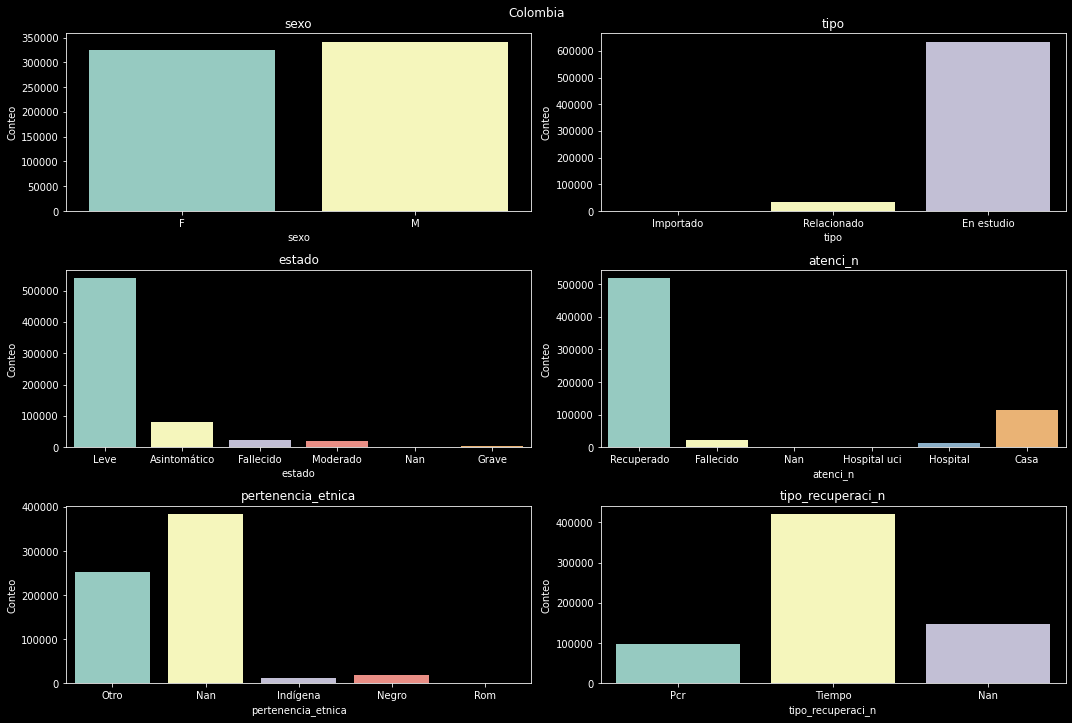

In [17]:
fig, axes = plt.subplots(3,2, figsize=(15,10))

axes = axes.ravel()

for i,col in enumerate(cat_cols):
    sns.countplot(df[col], ax=axes[i])
    axes[i].set_ylabel('Conteo')
    axes[i].set_title(str(col))

plt.suptitle('Colombia',x=0.5,y=1)
plt.tight_layout()
plt.show()

Finalmente, se chequeó la distribución de edades de los infectados en Colombia.

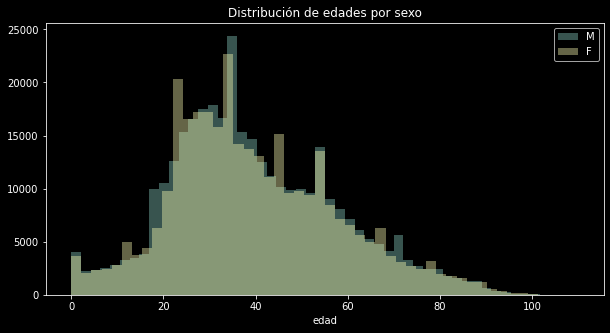

In [18]:
plt.figure(figsize=(10,5))
sns.distplot(df[df['sexo']=='M']['edad'], label = 'M', kde=False)
sns.distplot(df[df['sexo']=='F']['edad'], label = 'F', kde=False)

plt.title('Distribución de edades por sexo')
plt.legend()
plt.show()

No se encuentró mayor diferencia respecto a la distribución de acuerdo al sexo.

## Nivel Ciudad en el Top 5

### Exploración

Antes de continuar con el análisis se distinguieron aquellas ciudades que cuentan con el mayor número de contagios.

In [19]:
ciudades_top = df.groupby(by=['ciudad_de_ubicaci_n'], as_index=False).count()[['ciudad_de_ubicaci_n', 'edad']]
ciudades_top.rename(columns={'edad':'casos'},inplace=True)

Se guardan dichas ciudades en una variable para su posterior uso.

In [20]:
top_5 = list(ciudades_top.sort_values(by=['casos'], ascending=False)['ciudad_de_ubicaci_n'][:5])
print(top_5)

['Bogotá D.C.', 'Medellín', 'Cali', 'Barranquilla', 'Cartagena de Indias']


Se analizó gráficamente el total de casos en las ciudades mencionadas.

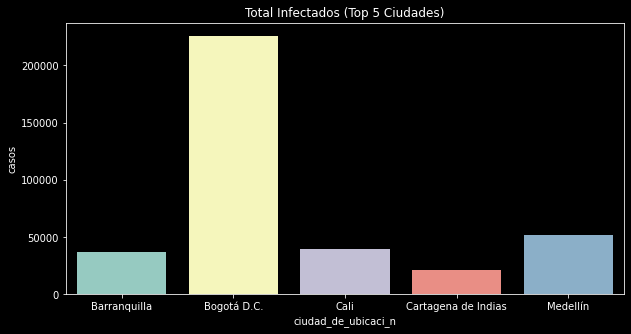

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='ciudad_de_ubicaci_n', y='casos', data=ciudades_top[ciudades_top['ciudad_de_ubicaci_n'].isin(top_5) ])
plt.title('Total Infectados (Top 5 Ciudades)')
plt.show()

Se encontró que Bogotá D.C cuenta con el mayor número de infectados.

Se realizó la extracción de las variables de interés para el modelado que se llevará a cabo posteriormente, así se distinguieron:
- Población de la Ciudad (P)
- Total de Muertes (M)
- Población Susceptible al contagio (S)
- Total de Infectados (I)
- Total de Recuperados (R)

In [22]:
cities_data = dict()
dates_df = pd.DataFrame(df["fecha_reporte_web"].unique(), columns=["fecha_reporte_web"])
dates = dates_df["fecha_reporte_web"].values
dates = matplotlib.dates.date2num(dates)
campos = ["fecha_reporte_web", "edad", "fecha_recuperado", "fecha_de_muerte"]

for city in top_5:
    cities_data[city] = dict()
    city_pop = list(poblacion_ciudades[poblacion_ciudades['Ciudad']==city]['Población'])[0]
    df_city = df[df["ciudad_de_ubicaci_n"] == city]
    
    history_cases = df_city.groupby("fecha_reporte_web", as_index=False).count()
    history_recovery = df_city.groupby("fecha_recuperado", as_index=False).count()
    history_death = df_city.groupby("fecha_de_muerte", as_index=False).count()
    history_cases = pd.merge(dates_df, history_cases, on="fecha_reporte_web", how="left", sort=True).fillna(0)["sexo"].values
    history_recovery = pd.merge(dates_df.rename(columns={"fecha_reporte_web": "fecha_recuperado"}), history_recovery, on="fecha_recuperado", how="left", sort=True).fillna(0)["sexo"].values
    history_death = pd.merge(dates_df.rename(columns={"fecha_reporte_web": "fecha_de_muerte"}), history_death, on="fecha_de_muerte", how="left", sort=True).fillna(0)["sexo"].values
    
    # Derivadas
    cities_data[city]["dSdt"] = - history_cases
    cities_data[city]["dRdt"] = history_recovery
    cities_data[city]["dMdt"] = history_death
    cities_data[city]["dIdt"] = - cities_data[city]["dSdt"] - cities_data[city]["dRdt"] - cities_data[city]["dMdt"]
    
    # Acumulados
    cities_data[city]["S"] = city_pop + cities_data[city]["dSdt"].cumsum()
    cities_data[city]["R"] = cities_data[city]["dRdt"].cumsum()
    cities_data[city]["M"] = cities_data[city]["dMdt"].cumsum()
    cities_data[city]["I"] = cities_data[city]["dIdt"].cumsum()

    #datos csv
    pd.DataFrame(cities_data[city]).to_csv('./spreadsheets/test_' + city + '.csv')

### Análisis Gráfico

#### Variables a Controlar

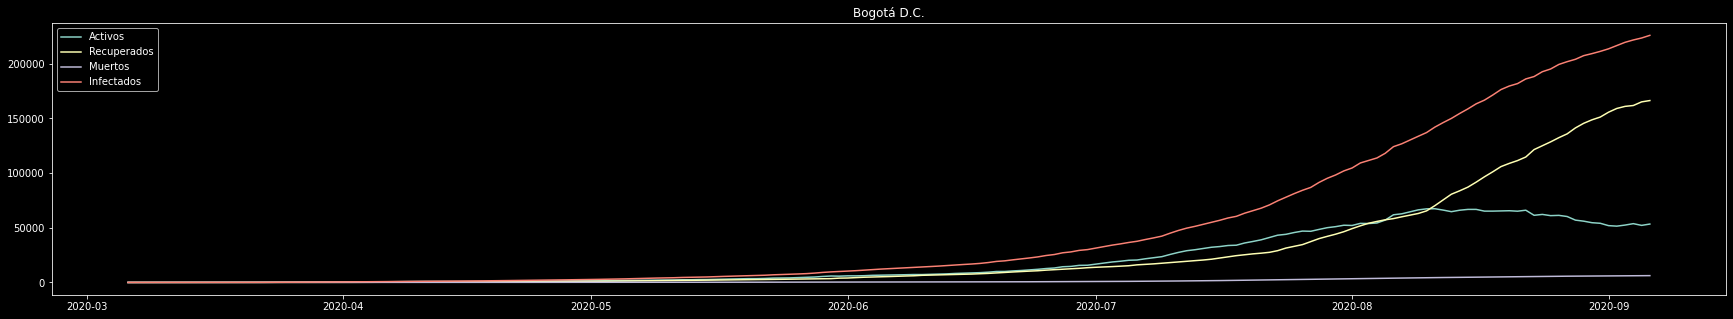

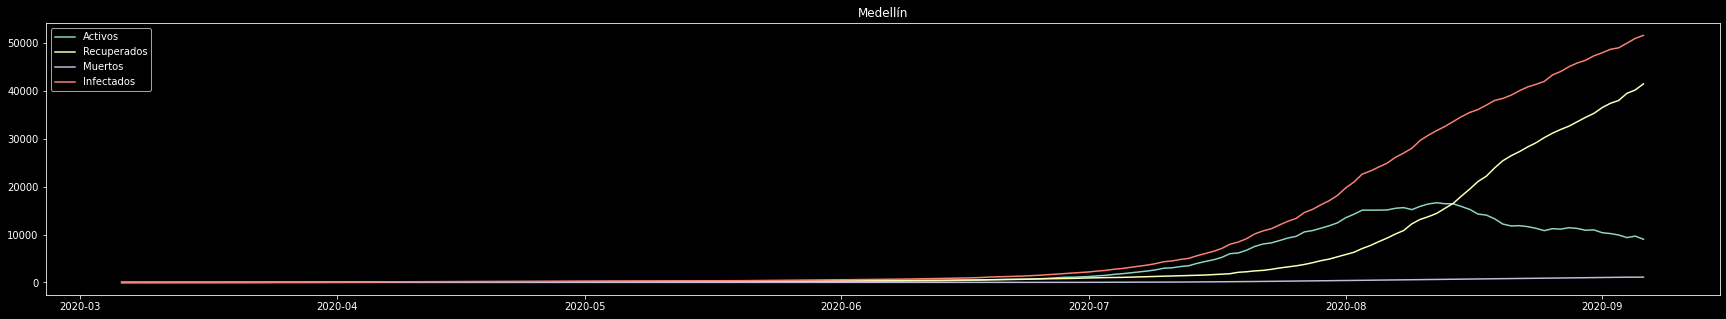

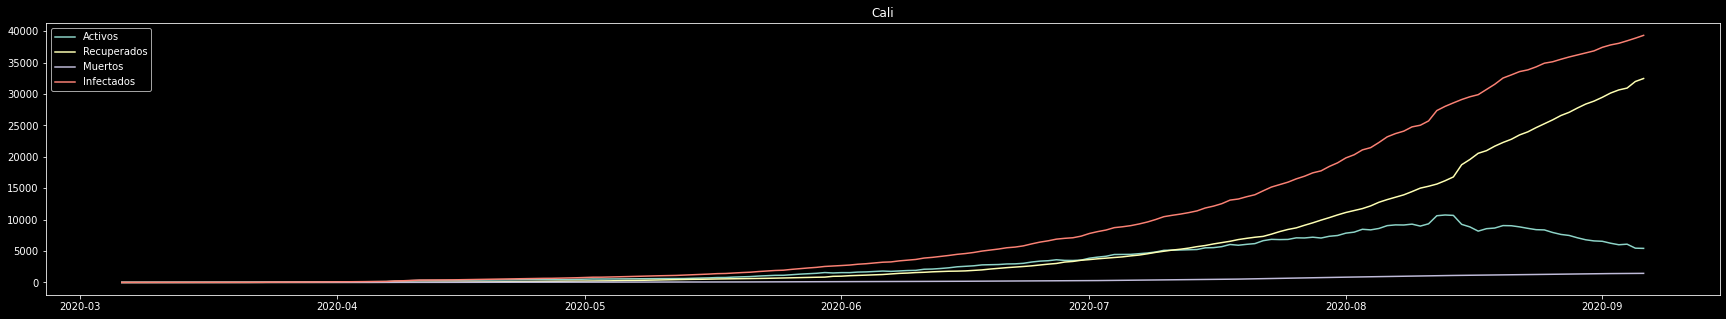

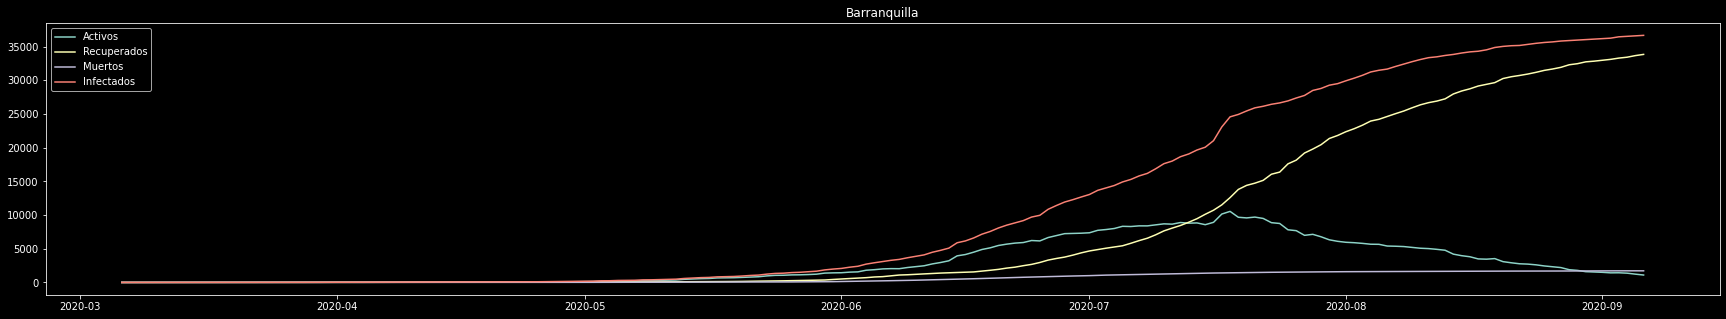

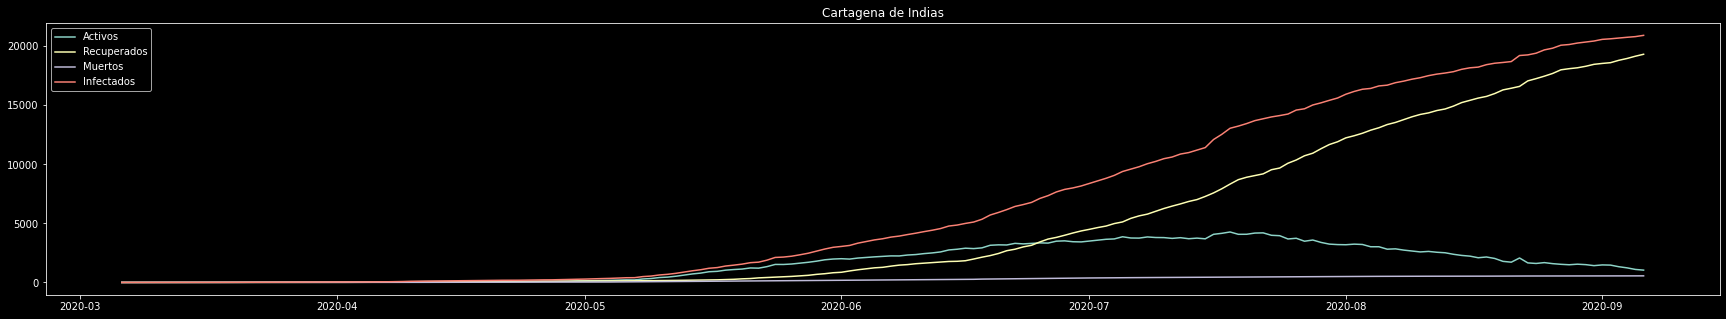

In [23]:
for city in top_5:    
    plt.figure(figsize=(30,5))
    plt.title(city)
    plt.plot_date(dates, cities_data[city]["I"], fmt="-")
    plt.plot_date(dates, cities_data[city]["R"], fmt="-")
    plt.plot_date(dates, cities_data[city]["M"], fmt="-")
    plt.plot_date(dates, -cities_data[city]["dSdt"].cumsum(), fmt="-")
    plt.legend(["Activos", "Recuperados", "Muertos", "Infectados"])
    # break

#### Histogramas
Se llevó a cabo un análisis gráfico de la distribución de edades (diferenciado por sexo) y ciudad.

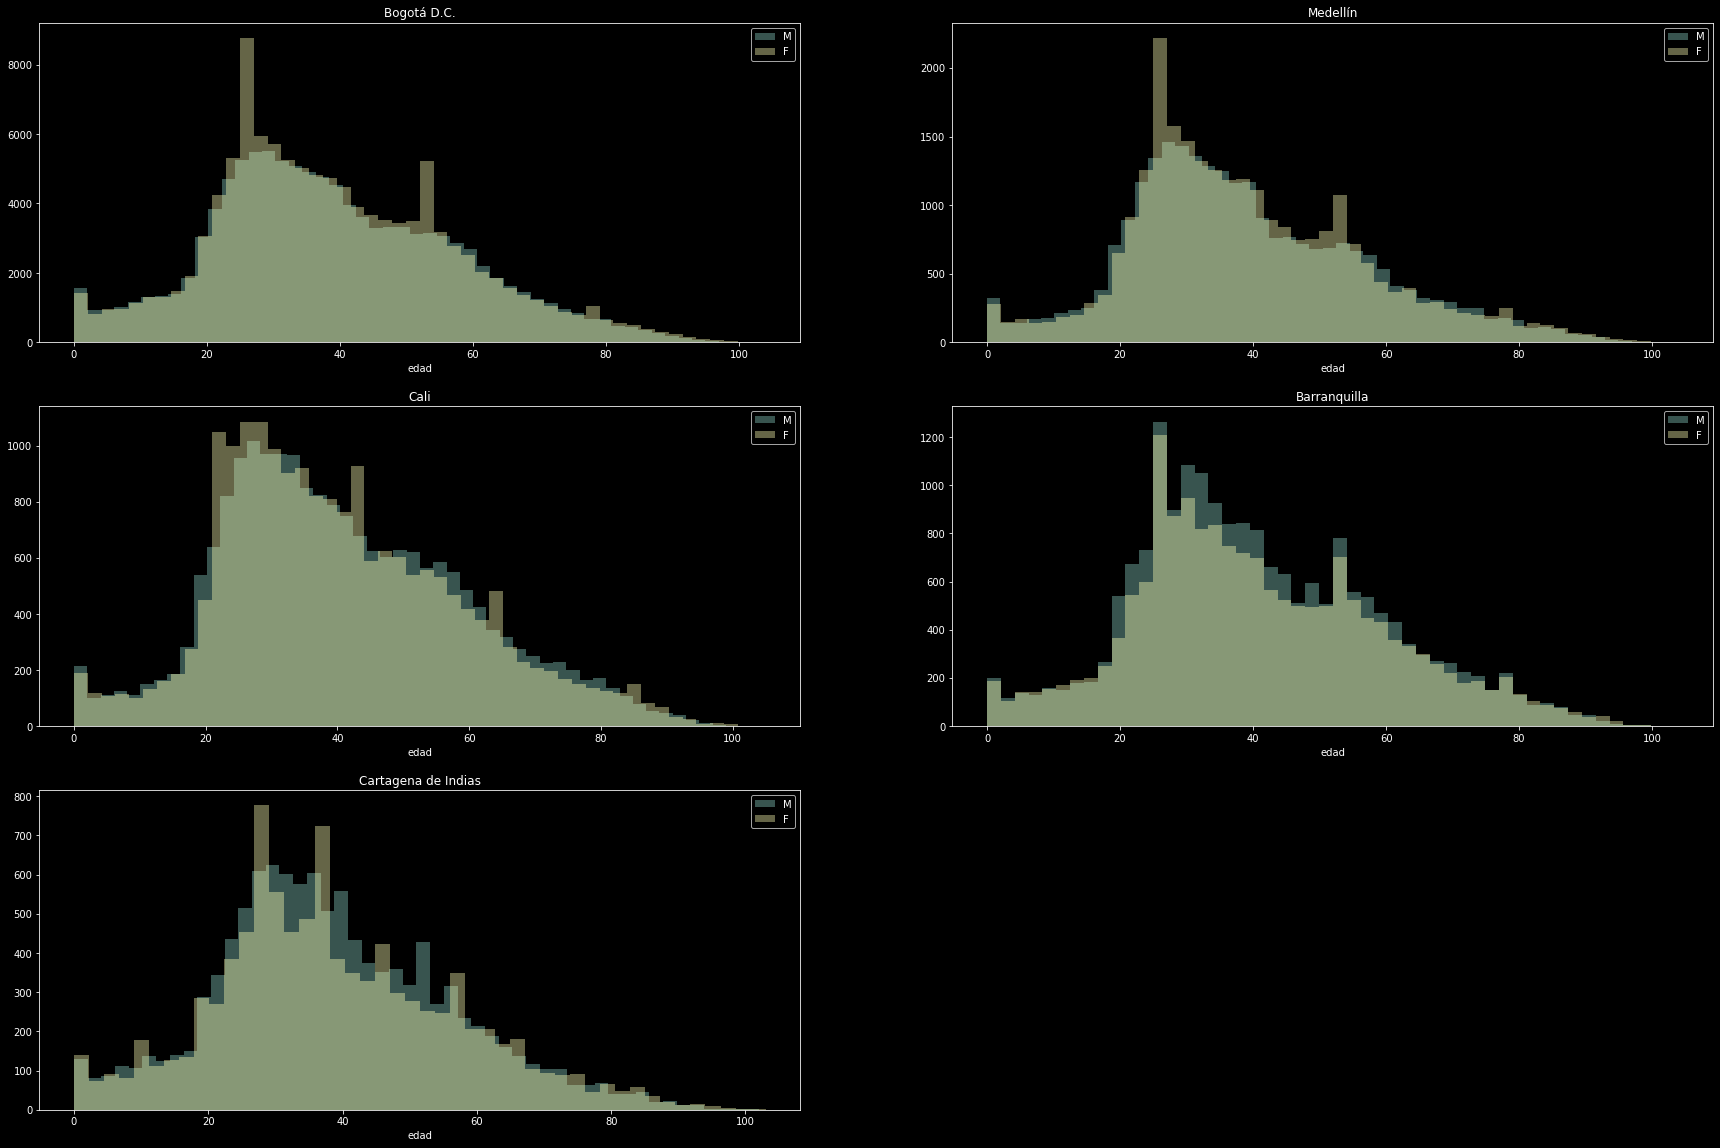

In [24]:
fig, axes = plt.subplots(3,2, figsize=(30,20))

for i, city in enumerate(top_5):
    ax = axes.flatten()[i]
    ax.set_title(city)
    sns.distplot(df[(df['ciudad_de_ubicaci_n']==city) & (df['sexo']=='M')]['edad'], label = 'M', kde=False, ax=ax)
    sns.distplot(df[(df['ciudad_de_ubicaci_n']==city) & (df['sexo']=='F')]['edad'], label = 'F', kde=False, ax=ax)
    ax.legend()
    
fig.delaxes(axes[2,1])

Se evidenció un comportamiento similar al del país, en el que no se encontró mayor diferencia entre las edades de los infectados.

#### Tasas de infección y recuperación

Se estimó la variación en el tiempo de las anteriores variables, las cuales se aprecian a continuación.

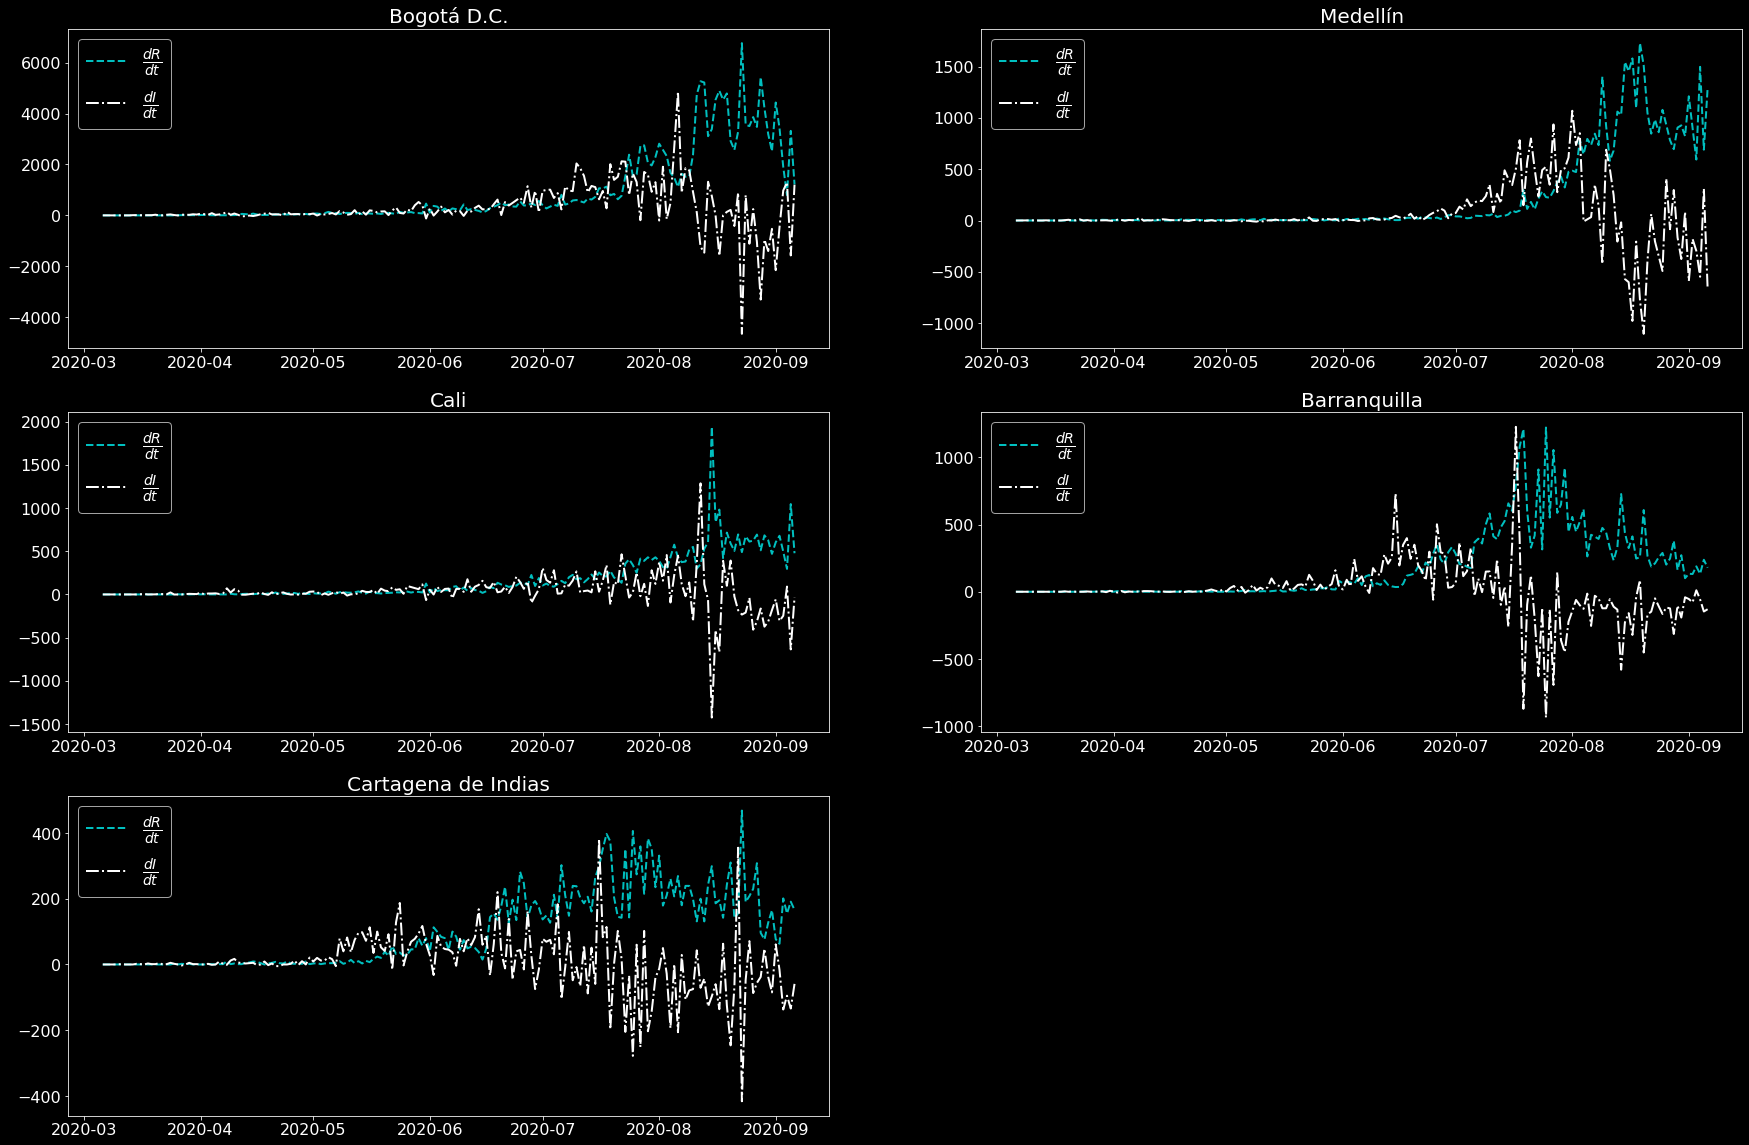

In [25]:
fig, axes = plt.subplots(3,2, figsize=(30,20))

for i, ciudad in enumerate(top_5):
    ax = axes.flatten()[i]
    ax.set_title(ciudad, fontsize=20)
    
    ax.plot_date(dates, cities_data[ciudad]['dRdt'], label=r'$\frac{dR}{dt}$', fmt='--', linewidth=2, color='c')
    ax.plot_date(dates, cities_data[ciudad]['dIdt'], label=r'$\frac{dI}{dt}$', fmt='-.', linewidth=2, color='w')
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    ax.legend(fontsize=20)

fig.delaxes(axes[2,1])

Se apreciaron fluctuaciones en ambas tasas, problablemente ligadas a las restricciones impuestas por el estado.

### Métricas

Ahora bien, a nivel de ciudad en lo corrido de la pandemia se encuentran las siguientes métricas.

In [26]:
df_agrupado = df[df['ciudad_de_ubicaci_n'].isin(top_5)].groupby(by=['ciudad_de_ubicaci_n', 'atenci_n'], as_index=False).count()[['ciudad_de_ubicaci_n', 'atenci_n', 'edad']]
df_agrupado.sort_values(by='ciudad_de_ubicaci_n', ascending = True, inplace=True)
df_agrupado.rename(columns={'edad':'casos'},inplace=True)
df_agrupado.head()

,ciudad_de_ubicaci_n,atenci_n,casos
0,Barranquilla,Casa,1080
1,Barranquilla,Fallecido,1629
2,Barranquilla,Hospital,10
3,Barranquilla,Hospital uci,4
4,Barranquilla,Nan,104


In [27]:
total_ciudad = df_agrupado.groupby(by=['ciudad_de_ubicaci_n'], as_index=False).sum()
total_ciudad.rename(columns={'casos':'infectados'},inplace=True)
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados
0,Barranquilla,36657
1,Bogotá D.C.,225947
2,Cali,39334
3,Cartagena de Indias,20922
4,Medellín,51618


In [28]:
total_ciudad['recuperados'] = df_agrupado[df_agrupado['atenci_n']=='Recuperado']['casos'].to_list()
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados,recuperados
0,Barranquilla,36657,33830
1,Bogotá D.C.,225947,166329
2,Cali,39334,32464
3,Cartagena de Indias,20922,19320
4,Medellín,51618,41491


In [29]:
total_ciudad['muertes'] = df_agrupado[df_agrupado['atenci_n']=='Fallecido']['casos'].to_list()
total_ciudad.head()

,ciudad_de_ubicaci_n,infectados,recuperados,muertes
0,Barranquilla,36657,33830,1629
1,Bogotá D.C.,225947,166329,5825
2,Cali,39334,32464,1362
3,Cartagena de Indias,20922,19320,529
4,Medellín,51618,41491,1040


# Feature Engineering

## Lag Plot

La gráfica "Lag" o "Shift" permite apreciar la relación de un evento `y(t+n)` respecto al valor real `y(t)`.

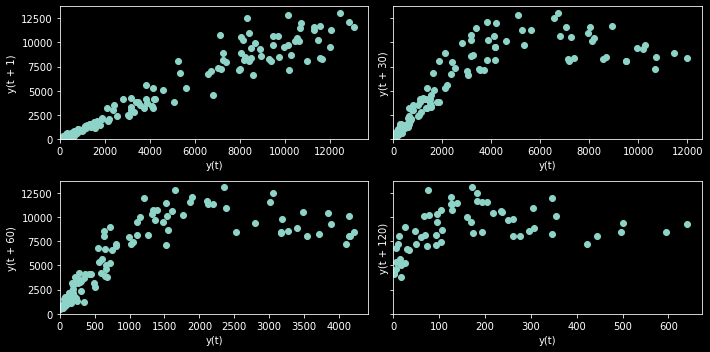

In [30]:
fig, axes = plt.subplots(2, 2,figsize=(10,5), sharex=False, sharey=True)
lags = [1,30,60,120]

for ax,i in enumerate(lags):
    ax = axes.flatten()[ax]
    ax = lag_plot(total_infecciones['casos'], lag=i, ax=ax)
    ax.set_xlim(0,)
    ax.set_ylim(0,)

plt.tight_layout()
plt.show()

## Autocorrelation
La gráfica de correlación permite estimar el número de valores `n` que se pueden tomar sin que esta transformación deteriore la relación de los datos.

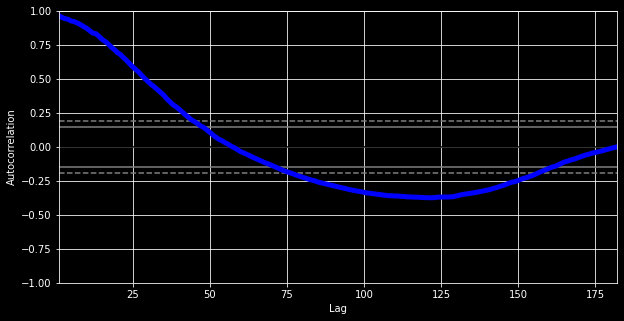

In [31]:
plt.figure(figsize=(10,5))
autocorrelation_plot(total_infecciones['casos'], linewidth=5, color='b')
plt.show()

Se apreció un alto coeficiente de autocorrelación para transformaciones que incluyan menos de 20 valores y un mínimo al rededor de los 12 días, es decir, 4 meses.

## Windowing

In [32]:
total_infecciones['roll_mean'] = total_infecciones['casos'].rolling(window=10).mean()
total_infecciones['roll_max'] = total_infecciones['casos'].rolling(window=2).max()
total_infecciones.describe()

,casos,roll_mean,roll_max
count,182.000000,173.000000,181.000000
mean,3662.203297,3634.257803,3918.624309
std,4049.094466,3965.961322,4280.342519
min,1.000000,10.400000,2.000000
25%,240.500000,248.900000,296.000000
50%,1525.500000,1502.500000,1604.000000
75%,7356.000000,7496.100000,8037.000000
max,13056.000000,11609.600000,13056.000000


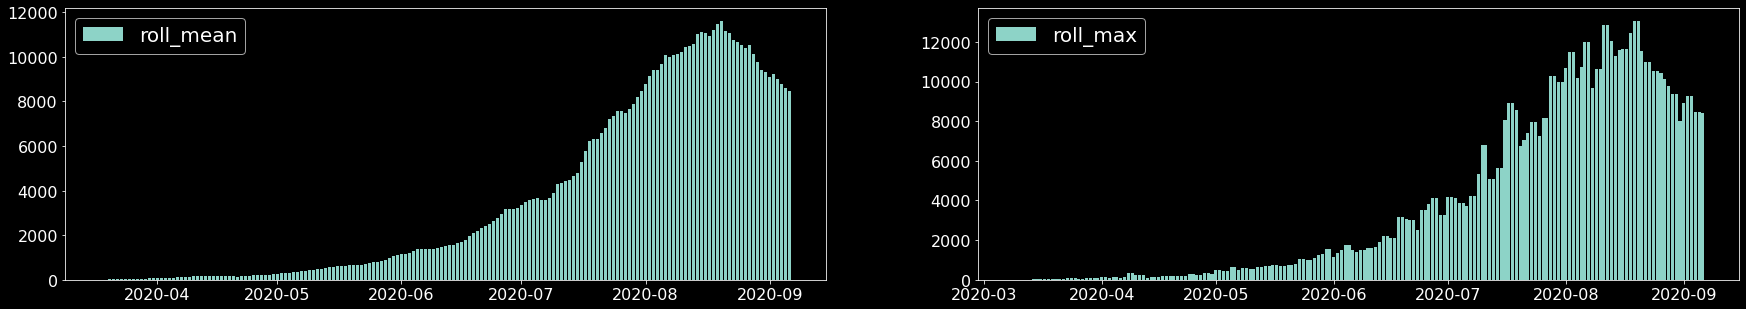

In [33]:
fig, axes = plt.subplots(1,2, figsize=(30,5))
for i, var in enumerate(['roll_mean','roll_max']):
    ax = axes.flatten()[i]
    axes[i].bar(total_infecciones['fecha_reporte_web'], total_infecciones[var], label=var)
# axes[1].bar(total_infecciones['fecha_reporte_web'], total_infecciones['roll_max'], label='roll_max')
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    # ax.set_ylabel('',fontsize=18)
plt.show()

## Expanding

In [34]:
total_infecciones['exp_mean'] = total_infecciones['casos'].expanding().mean()
total_infecciones['exp_max'] = total_infecciones['casos'].expanding().max()
total_infecciones.head(3)

,fecha_reporte_web,casos,roll_mean,roll_max,exp_mean,exp_max
0,2020-03-06,1,NaN,NaN,1.0,1.0
1,2020-03-09,2,NaN,2.0,1.5,2.0
2,2020-03-11,6,NaN,6.0,3.0,6.0


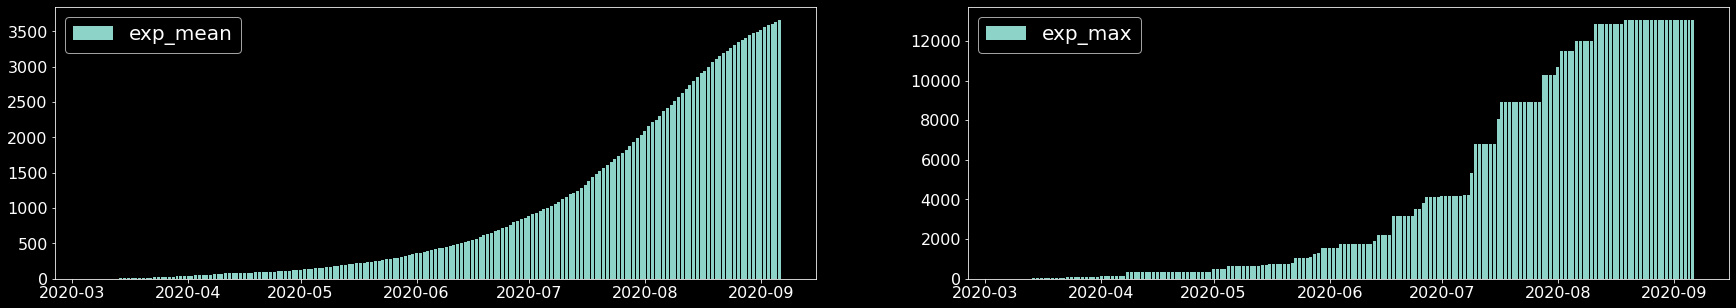

In [35]:
fig, axes = plt.subplots(1,2, figsize=(30,5))
for i, var in enumerate(['exp_mean','exp_max']):
    ax = axes.flatten()[i]
    axes[i].bar(total_infecciones['fecha_reporte_web'], total_infecciones[var], label=var)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
# axes[1].bar(total_infecciones['fecha_reporte_web'], total_infecciones['exp_max'])
plt.show()

# Definición de los Modelos

## Modelo SIR

### Definición

In [36]:
class SIR:
    def __init__(self, population, n):
        self.beta = []
        self.gamma = []
        self.mu = []
        self.population = population
        self.n = n
        
    def obj_func(self, params, data, t, y0):
        beta, gamma, mu = params
        preds = odeint(self.model, y0, t, args=(beta, gamma, mu))
        err = np.sum(np.square(preds.T - data))
        
        return err
        
    def fit(self, y0, t, data):
        results = np.array([[x] for x in y0])
        for i in range(0, len(t), self.n):
            ti = list(range(len(t[i:i + self.n])))
            
            # Find parameter values that minimizes the error between the model and the real data
            params = minimize(self.obj_func, (0, 0, 0), args=(data[:, i:i + self.n], ti, results[:, -1]), bounds=((0, None), (0, None), (0, None)))
            beta, gamma, mu = params.x
            
            self.beta.append(beta)
            self.gamma.append(gamma)
            self.mu.append(mu)

            result_i = odeint(self.model, results[:, -1], ti, args=(beta, gamma, mu))
            results = np.concatenate((results, result_i.T), axis=1)
            
            self.last_value = results[:, -1]
            
        # self.beta = pd.Series(self.beta).ewm(alpha=0.2).mean().values
        # self.gamma = pd.Series(self.gamma).ewm(alpha=0.2).mean().values
        # self.mu = pd.Series(self.mu).ewm(alpha=0.2).mean().values
        self.results = results
    
    def predict(self, days):
        weights = [0.5, 0.3, 0.2]
        beta = np.average(self.beta[-3:], weights=weights)
        gamma = np.average(self.gamma[-3:], weights=weights)
        mu = np.average(self.mu[-3:], weights=weights)
        
        t = list(range(days))
        
        return odeint(self.model, self.last_value, t, args=(beta, gamma, mu)).T
    
    def model(self, y, t, beta, gamma, mu):
        Y = np.zeros((4))
        V = y
        #dS/dt SUCEPTIBLES
        Y[0] = - beta * V[0] * V[1] / self.population
        #dI/dt INFECTADOS
        Y[1] = beta * V[0] * V[1] / self.population - gamma * V[1] - mu * V[1]
        #dR/dt RECUPERADOS
        Y[2] = gamma * V[1] #gama1-20*infectados1-20+gama20-40*infectados20-40
        #dM/dt MUERTES
        Y[3] = mu * V[1]

        return Y
          

### Cálculo

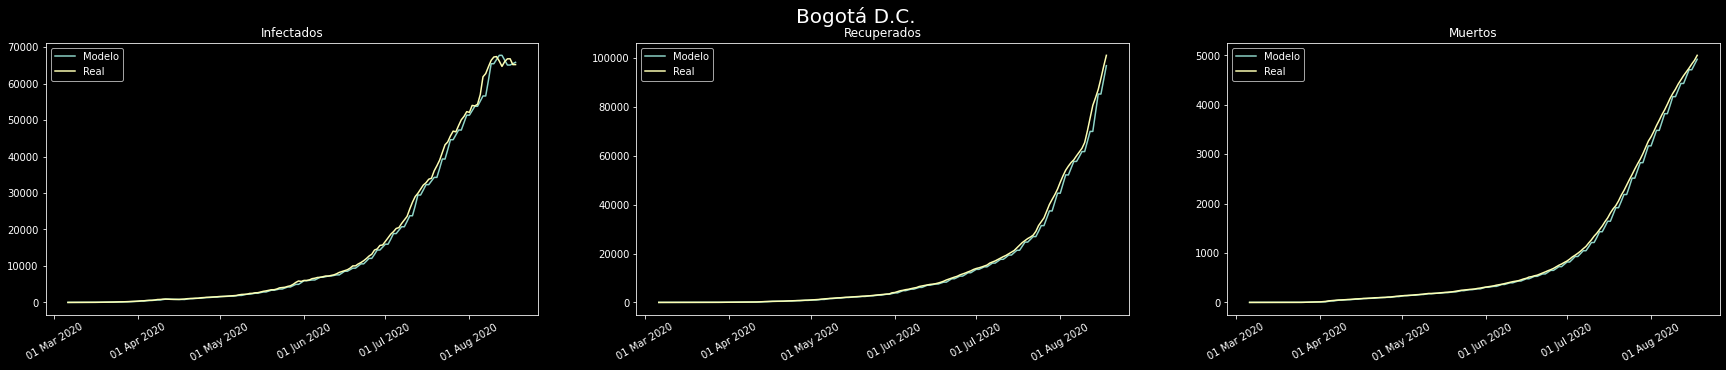

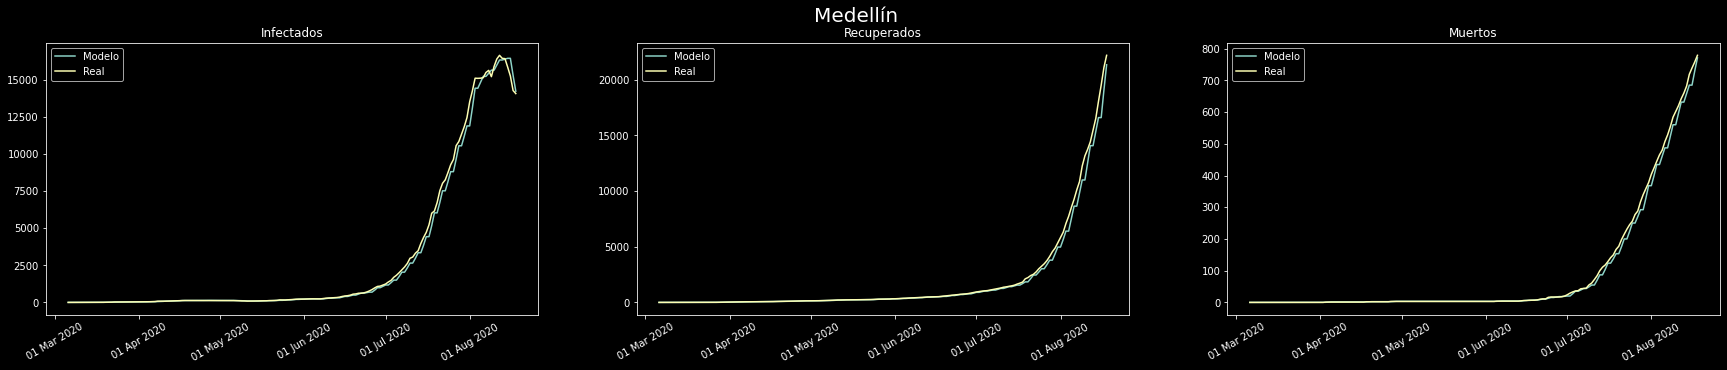

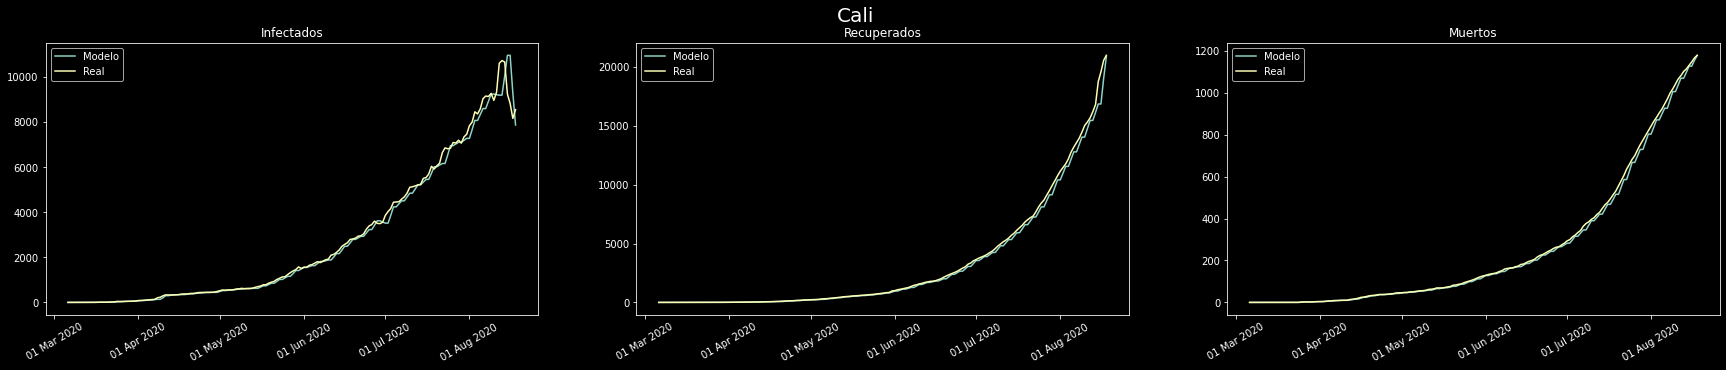

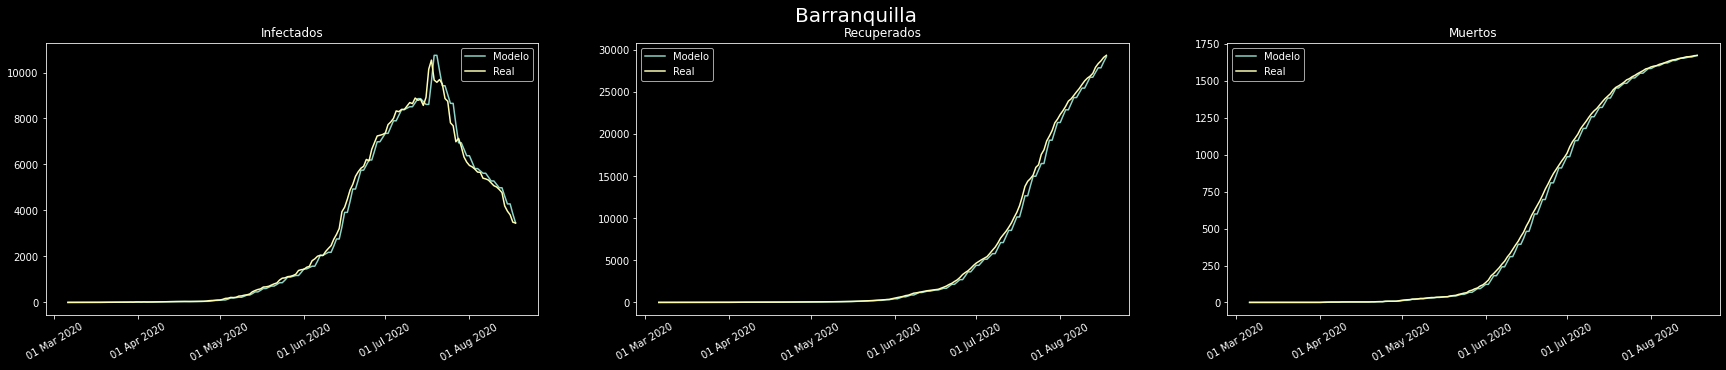

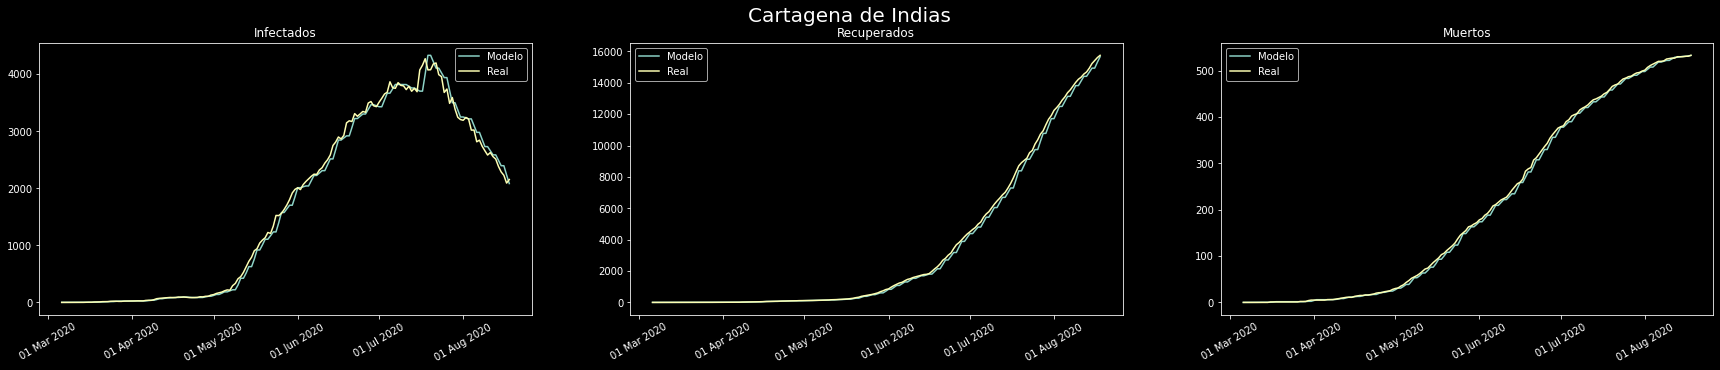

In [37]:
cutpoint = int(len(dates_df) * 0.9)
models = dict()

for city in top_5:
    city_pop = list(poblacion_ciudades[poblacion_ciudades['Ciudad']==city]['Población'])[0]
    data = np.array([
        cities_data[city]["S"],
        cities_data[city]["I"],
        cities_data[city]["R"],
        cities_data[city]["M"],
    ])
    
    train_data = data[:, :cutpoint]
    t = np.arange(train_data.shape[1])
    
    model = SIR(city_pop, 3)
    
    y0 = [city_pop, 1, 0, 0]
    model.fit(y0, t, train_data)
    models[city] = model
    ## FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(30,5))
    fig.suptitle(city, fontsize= 20)
    axes = axes.flatten()

    # Infectados
    axes[0].plot_date(dates[:cutpoint] , models[city].results[1][:cutpoint], fmt="-")
    axes[0].plot_date(dates[:cutpoint], train_data[1], fmt="-")
    axes[0].legend(["Modelo", "Real"])
    axes[0].set_title("Infectados")
    axes[0].xaxis.set_major_formatter(formatter)
    axes[0].xaxis.set_tick_params(rotation=30, labelsize=10)
    
    # Recuperados
    axes[1].plot_date(dates[:cutpoint], models[city].results[2][:cutpoint], fmt="-")
    axes[1].plot_date(dates[:cutpoint], train_data[2], fmt="-")
    axes[1].legend(["Modelo", "Real"])
    axes[1].set_title("Recuperados")
    axes[1].xaxis.set_major_formatter(formatter)
    axes[1].xaxis.set_tick_params(rotation=30, labelsize=10)
    
    # Muertos
    axes[2].plot_date(dates[:cutpoint], models[city].results[3][:cutpoint], fmt="-")
    axes[2].plot_date(dates[:cutpoint], train_data[3], fmt="-")
    axes[2].legend(["Modelo", "Real"])
    axes[2].set_title("Muertos")
    axes[2].xaxis.set_major_formatter(formatter)
    axes[2].xaxis.set_tick_params(rotation=30, labelsize=10)

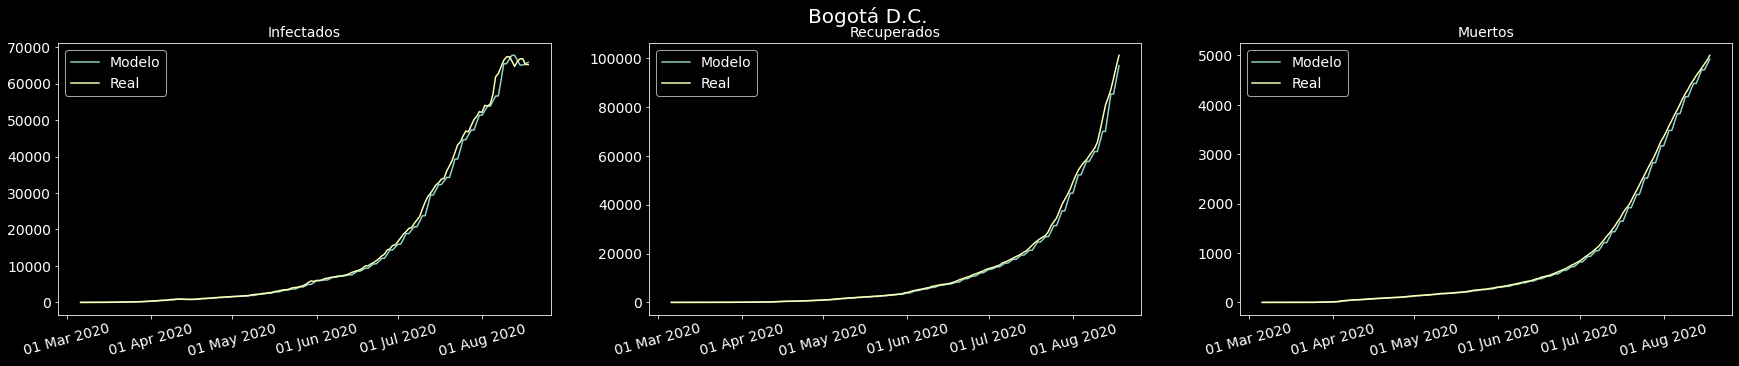

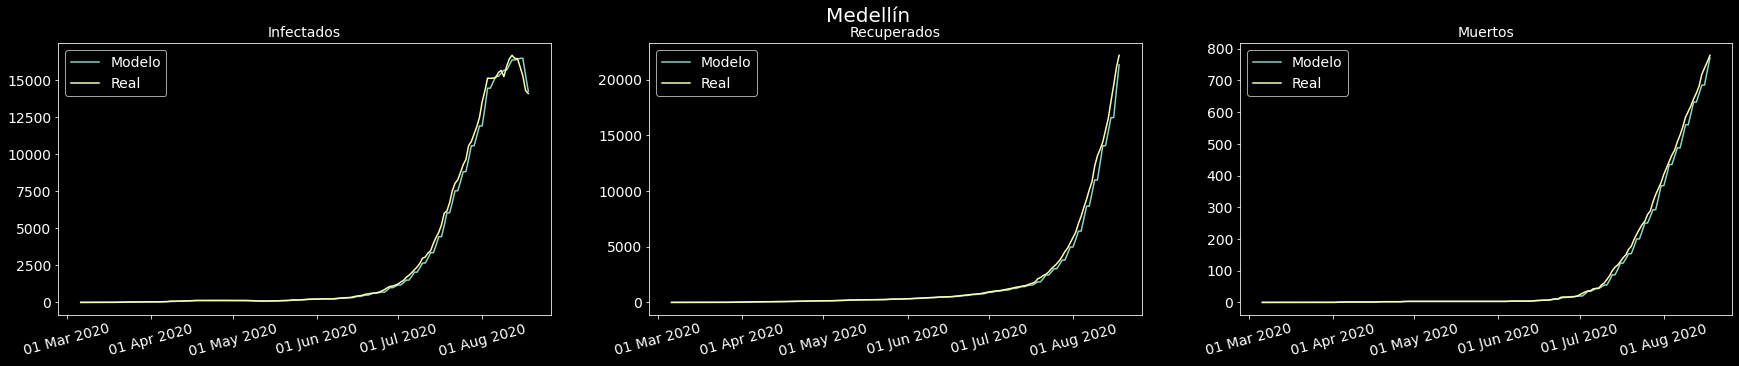

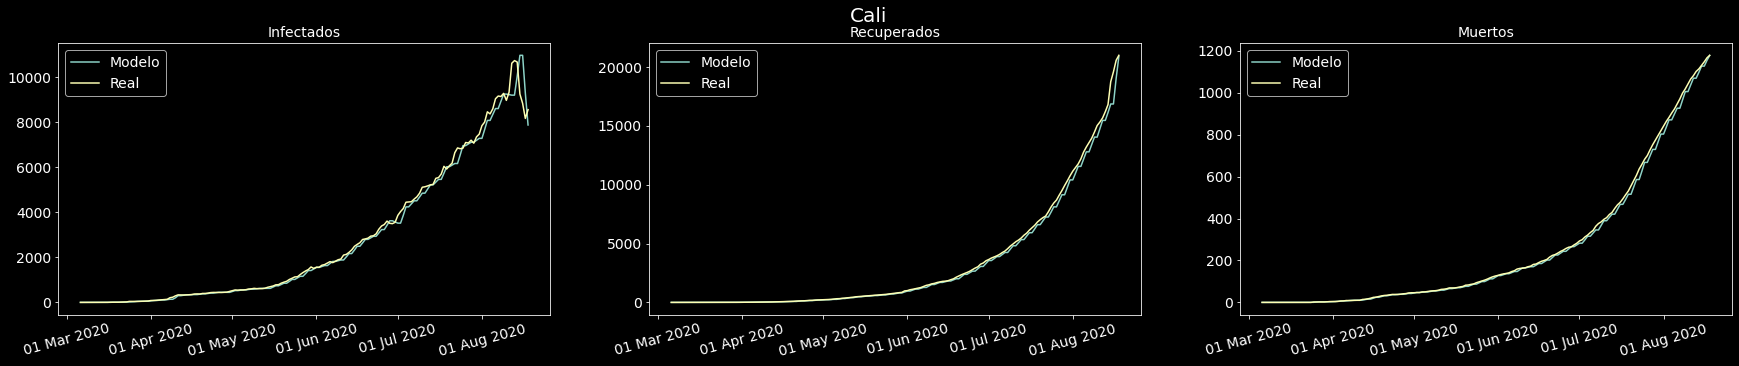

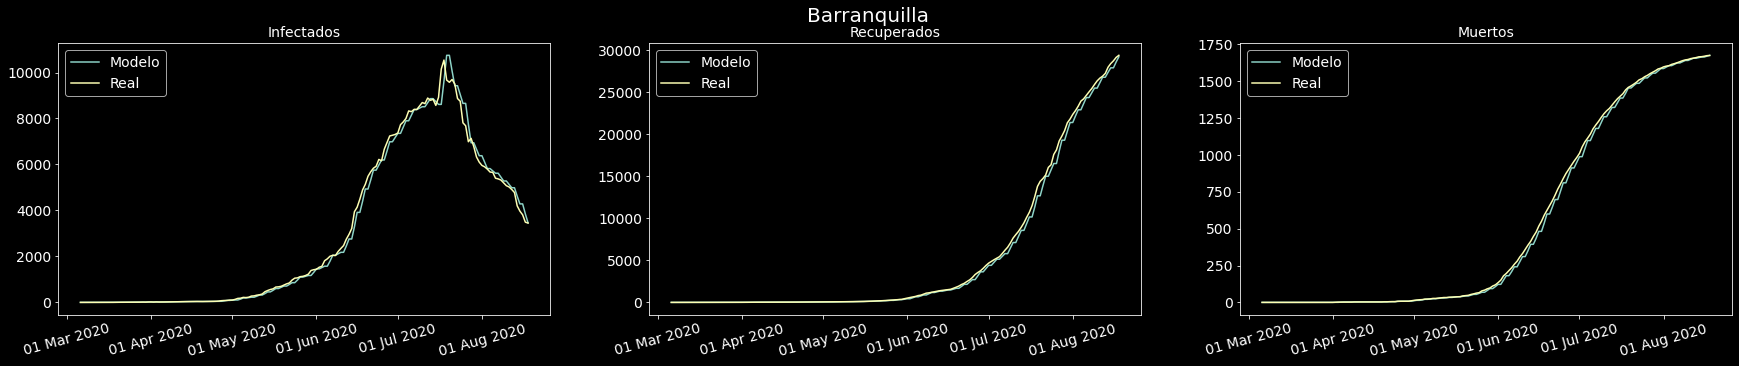

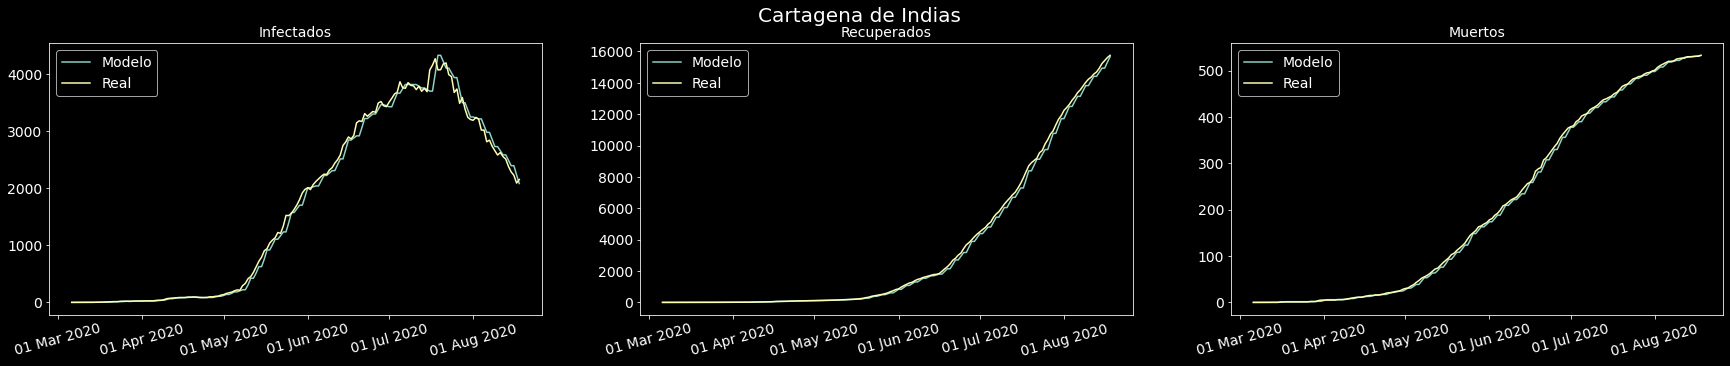

In [38]:
for city in top_5:
    ## FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(30,5))
    fig.suptitle(city, fontsize= 20)
    for i, var in enumerate(['Infectados','Recuperados','Muertos']):
        ax = axes.flatten()
        data = np.array([
            cities_data[city]["S"],
            cities_data[city]["I"],
            cities_data[city]["R"],
            cities_data[city]["M"],
        ])
    
        train_data = data[:, :cutpoint]

        ax[i].plot_date(dates[:cutpoint] , models[city].results[i + 1][:cutpoint], fmt="-")
        ax[i].plot_date(dates[:cutpoint], train_data[i + 1], fmt="-")
        ax[i].legend(["Modelo", "Real"],fontsize=14)
        ax[i].set_title(var, fontsize=14)
        ax[i].xaxis.set_major_formatter(formatter)
        ax[i].xaxis.set_tick_params(rotation=15, labelsize=14)
        ax[i].yaxis.set_tick_params(labelsize=14)

### Predicciones sobre el conjunto de test

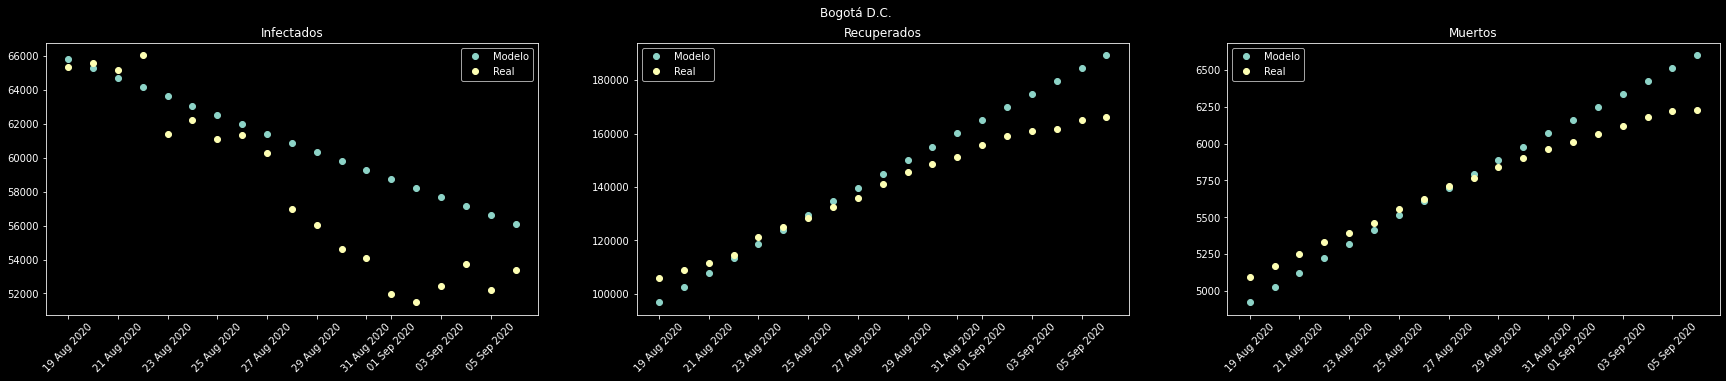

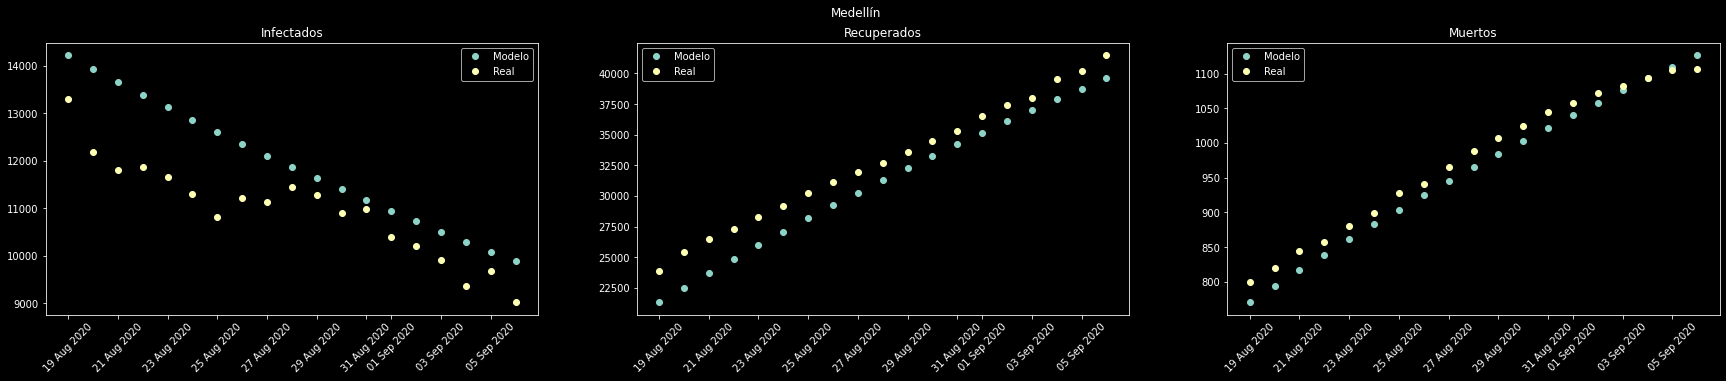

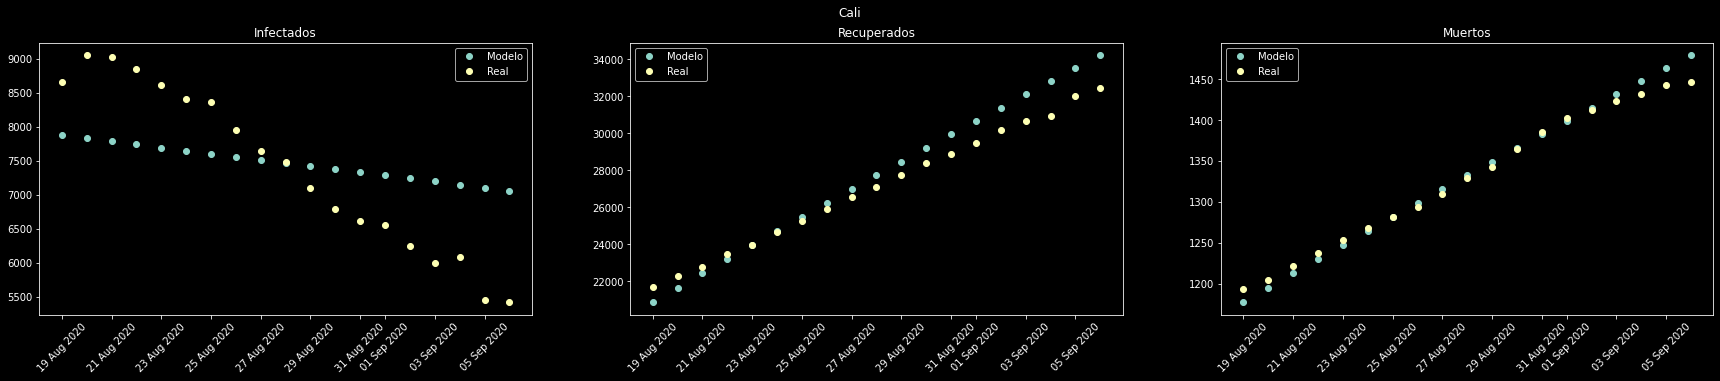

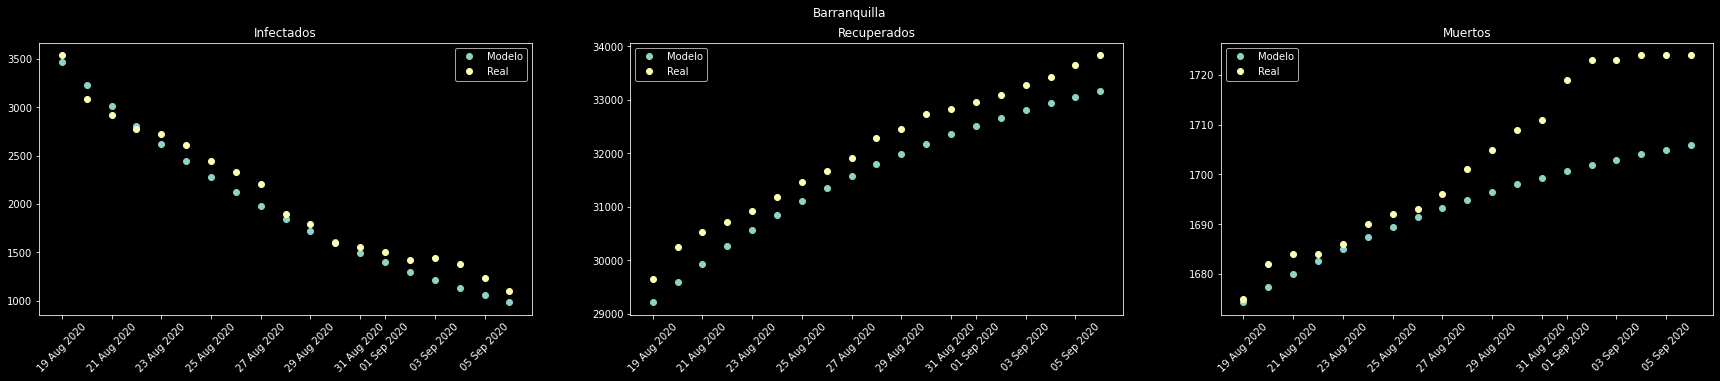

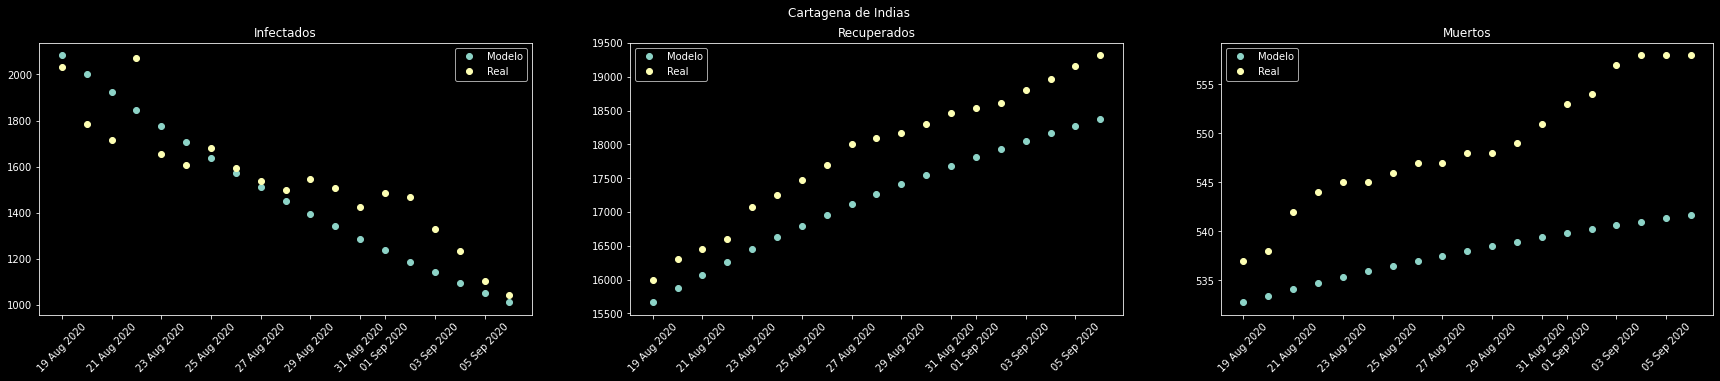

In [39]:
for city in top_5:
    city_pop = list(poblacion_ciudades[poblacion_ciudades['Ciudad']==city]['Población'])[0]
    data = np.array([
        cities_data[city]["S"],
        cities_data[city]["I"],
        cities_data[city]["R"],
        cities_data[city]["M"],
    ])
    test_data = data[:, cutpoint:]
    days = data.shape[1] - cutpoint
    t = np.arange(days)
    preds = models[city].predict(days)
    
    ## FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(30,5))
    fig.suptitle(city)
    axes = axes.flatten()
    
    # Infectados
    axes[0].plot_date(dates[cutpoint:], preds[1])
    axes[0].plot_date(dates[cutpoint:], test_data[1])
    axes[0].legend(["Modelo", "Real"])
    axes[0].set_title("Infectados")
    axes[0].xaxis.set_major_formatter(formatter)
    axes[0].xaxis.set_tick_params(rotation=45, labelsize=10)
    
    # Recuperados
    axes[1].plot_date(dates[cutpoint:], preds[2])
    axes[1].plot_date(dates[cutpoint:], test_data[2])
    axes[1].legend(["Modelo", "Real"])
    axes[1].set_title("Recuperados")
    axes[1].xaxis.set_major_formatter(formatter)
    axes[1].xaxis.set_tick_params(rotation=45, labelsize=10)
    
    # Muertos
    axes[2].plot_date(dates[cutpoint:], preds[3])
    axes[2].plot_date(dates[cutpoint:], test_data[3])
    axes[2].legend(["Modelo", "Real"])
    axes[2].set_title("Muertos")
    axes[2].xaxis.set_major_formatter(formatter)
    axes[2].xaxis.set_tick_params(rotation=45, labelsize=10)

## Modelo ARIMA

/home/dogeubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dogeubuntu/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


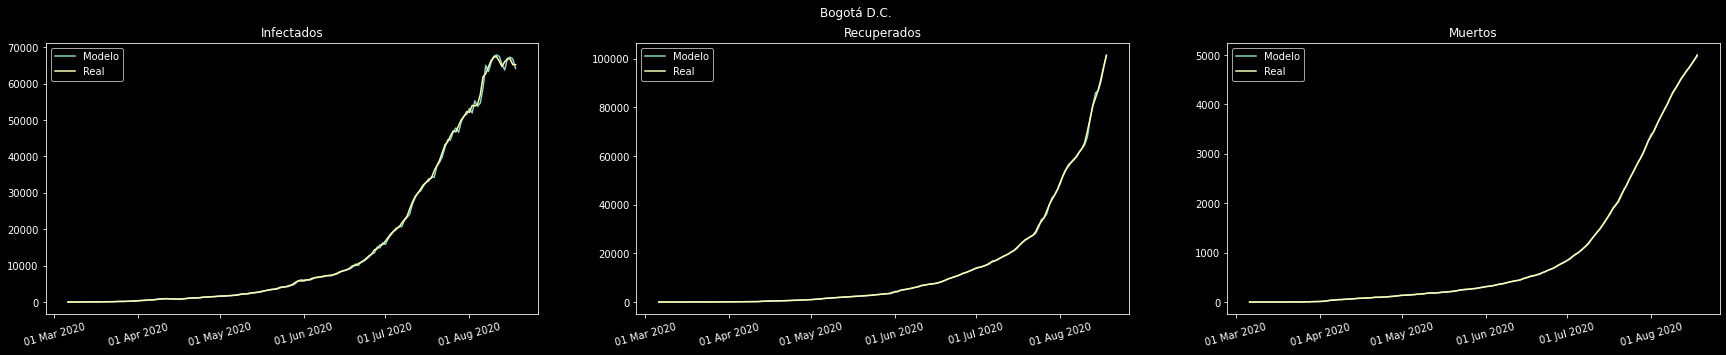

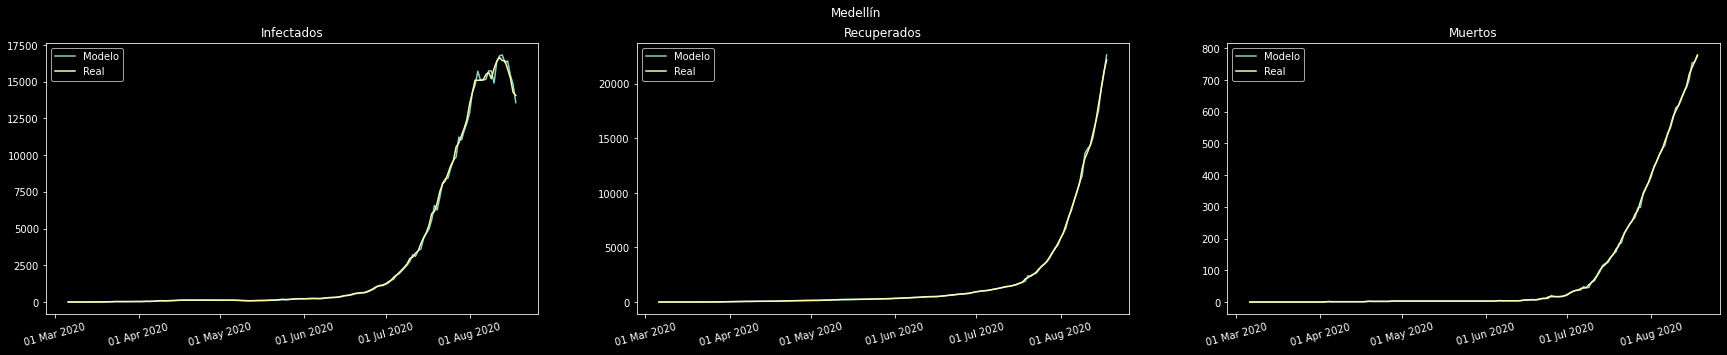

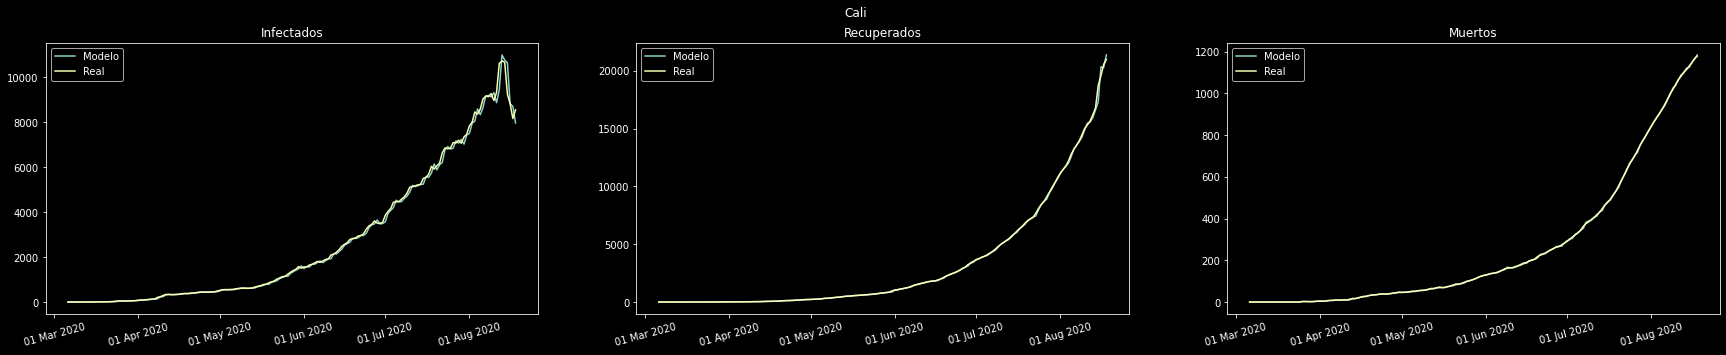

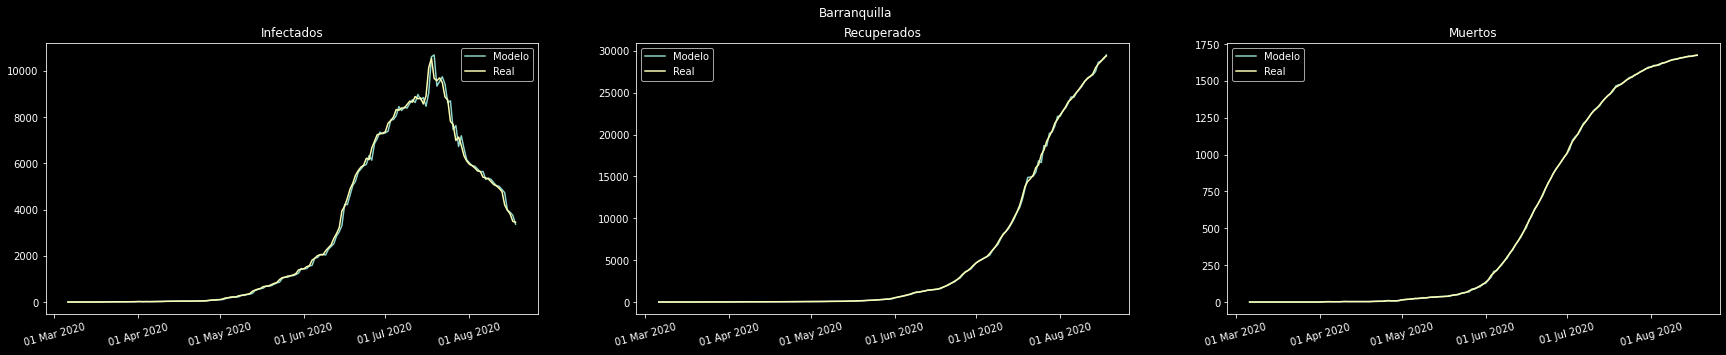

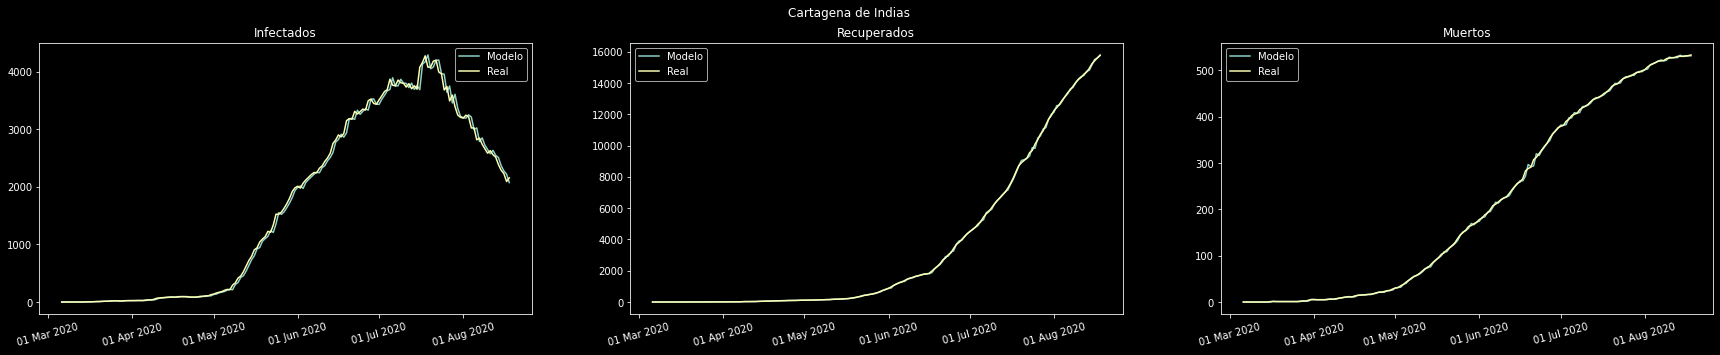

In [40]:
# Diferencia
def difference(dataset, interval=1):
    diff = [0]
    for i in range(interval,len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# Invertir diferencia
def inverse_difference(dataset, y, interval=1):
    idiff=[dataset[0]]
    for i in range(interval, len(dataset)):
        inverse=y[i]+dataset[i-interval]
        idiff.append(inverse)
    return np.array(idiff)

ARIMA_models = dict()
predicted=dict()
var=['S','I','R','M']
fitted=dict()

for city in top_5:
    ARIMA_models[city]=dict()
    predicted[city]=dict()
    fitted[city]=dict()
    data = np.array([
        cities_data[city]["S"],
        cities_data[city]["I"],
        cities_data[city]["R"],
        cities_data[city]["M"],
    ])
    
    train_data = data[:, :cutpoint]
    for x in var:
        data_x =cities_data[city][x]
        train_data_x = data_x[:cutpoint]
      
        # modelo
        model = ARIMA(train_data_x, order=(1,1,0), enforce_stationarity=False)
        # Estimación de parámetros
        model_fit = model.fit()
        fitted[city][x]=model_fit
        # Resultados
        fit=model_fit.fittedvalues
        predict=model_fit.forecast(steps=days)
        result=np.concatenate((fit,predict),axis=0)
        ARIMA_models[city][x] = result[:cutpoint]
        predicted[city][x] = result[cutpoint:]
        # AIC,BIC
        AIC = model_fit.aic
        BIC = model_fit.bic
   
    # FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(30,5))
    fig.suptitle(city)
    axes = axes.flatten()

    # Infectados
    axes[0].plot_date(dates[:cutpoint] , ARIMA_models[city]['I'][:cutpoint], fmt="-")
    axes[0].plot_date(dates[:cutpoint], train_data[1], fmt="-")
    axes[0].legend(["Modelo", "Real"])
    axes[0].set_title("Infectados")
    axes[0].xaxis.set_major_formatter(formatter)
    axes[0].xaxis.set_tick_params(rotation=15, labelsize=10)
    
    # Recuperados
    axes[1].plot_date(dates[:cutpoint], ARIMA_models[city]['R'][:cutpoint], fmt="-")
    axes[1].plot_date(dates[:cutpoint], train_data[2], fmt="-")
    axes[1].legend(["Modelo", "Real"])
    axes[1].set_title("Recuperados")
    axes[1].xaxis.set_major_formatter(formatter)
    axes[1].xaxis.set_tick_params(rotation=15, labelsize=10)
    
    # Muertos
    axes[2].plot_date(dates[:cutpoint], ARIMA_models[city]['M'][:cutpoint], fmt="-")
    axes[2].plot_date(dates[:cutpoint], train_data[3], fmt="-")
    axes[2].legend(["Modelo", "Real"])
    axes[2].set_title("Muertos")
    axes[2].xaxis.set_major_formatter(formatter)
    axes[2].xaxis.set_tick_params(rotation=15, labelsize=10)

# Pronóstico de los modelos

Se propone asignar un peso a cada modelo de acuerdo a la exactitud de cada uno. El modelo ARIMA al ser un modelo lineal puede ser confiable para los primeros 10 días, mientras que para los siguientes días el modelo SIR es un mejor estimador.

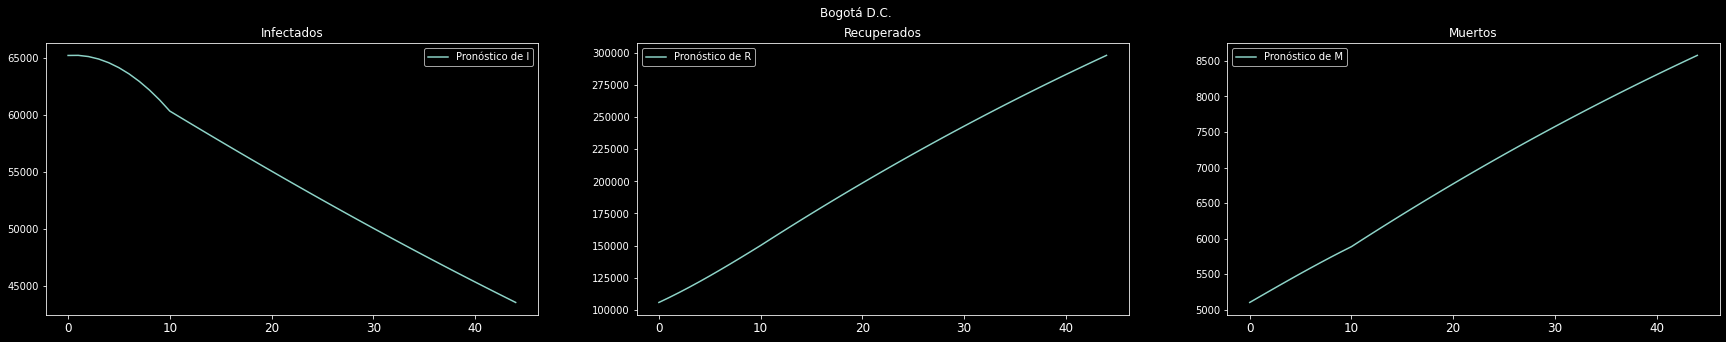

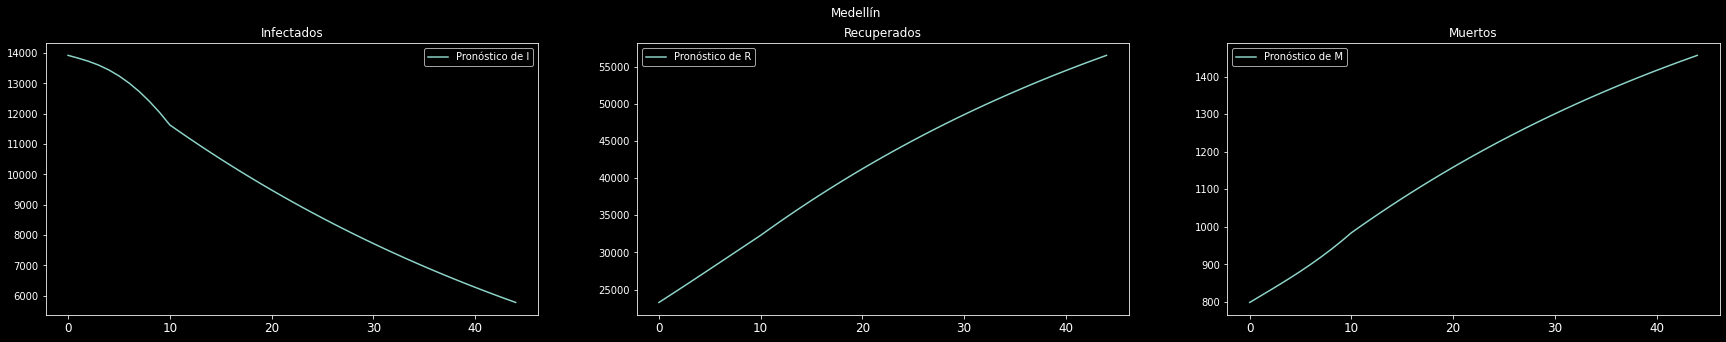

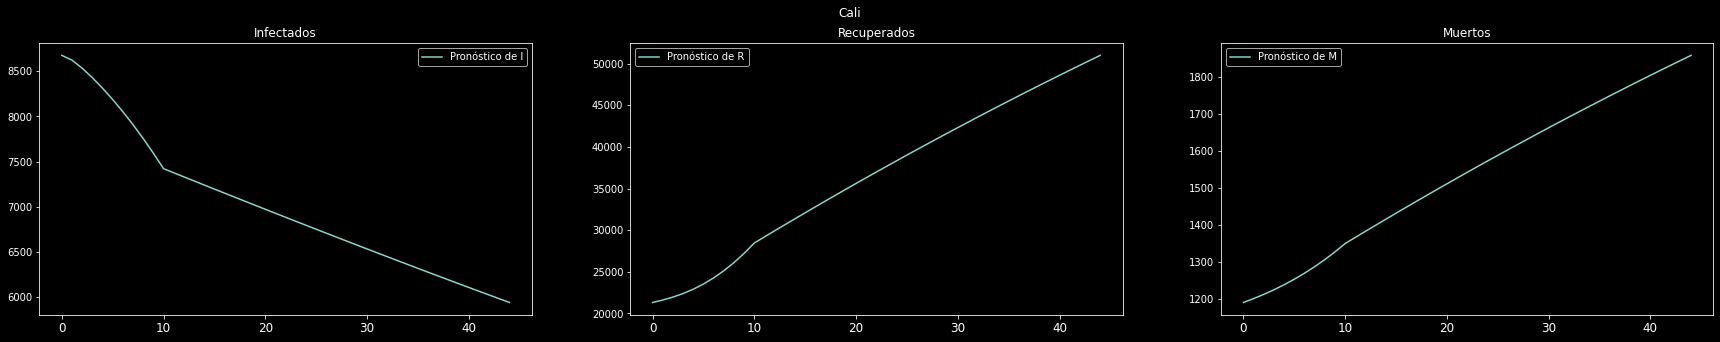

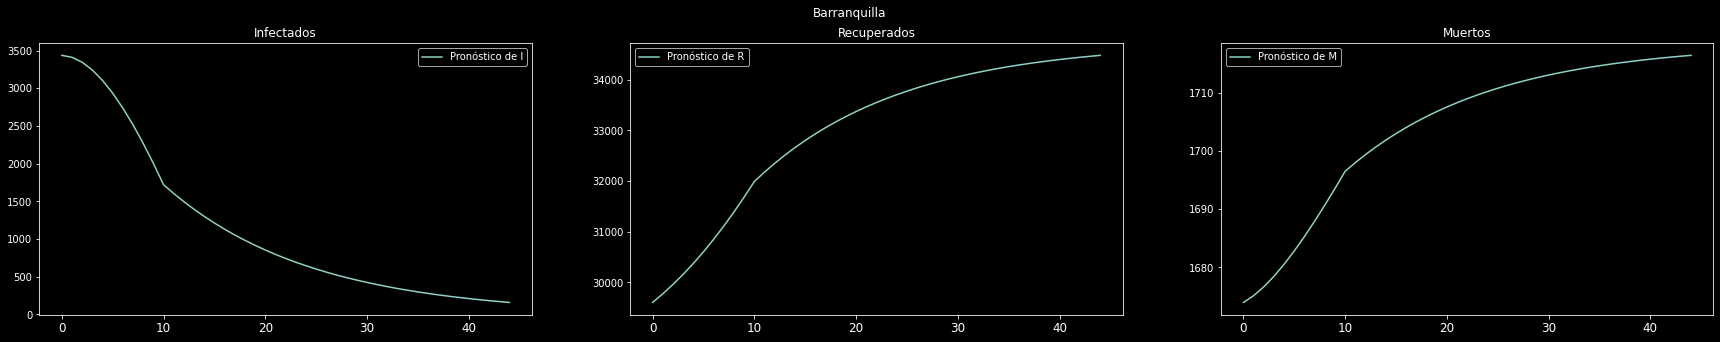

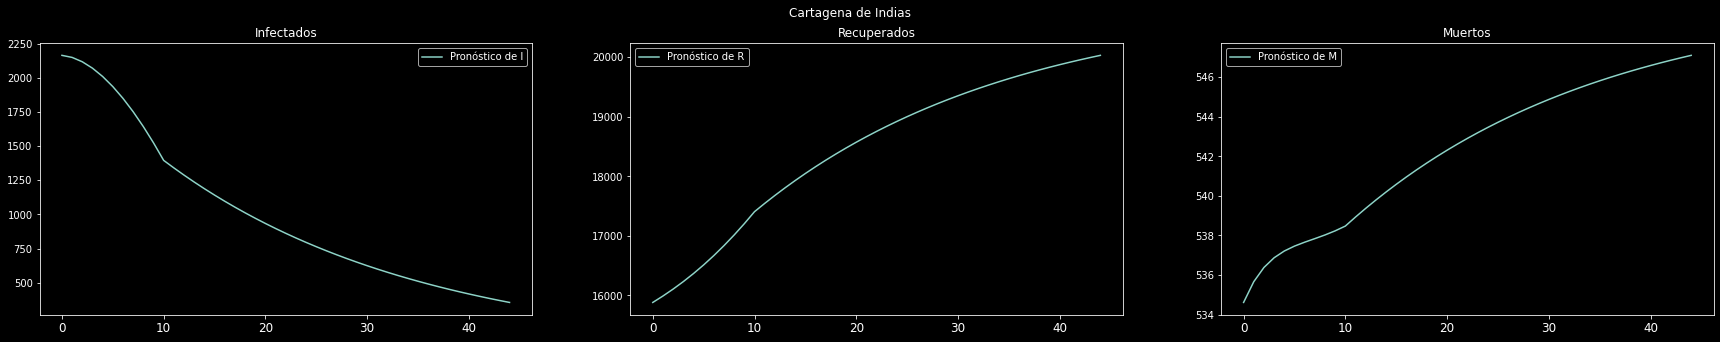

In [41]:
days_ARIMA = 10 # días en los que el ARIMA tiene validez
days = 45
forecast_mixed = {}
for city in top_5:
    forecast_mixed[city]={'S':[],'I':[],'R':[],'M':[]}
    W_ARIMA = [1-t/days_ARIMA for t in range(days_ARIMA)] + [0 for t in range(days - days_ARIMA)]
    W_SIR = [1-w_arima for w_arima in W_ARIMA]
    SIR_result=models[city].predict(days)
    i=0
    for x in forecast_mixed[city]:
        # ARIMA_result=fitted[city][x].forecast(steps=days)
        forecast_mixed[city][x]=W_ARIMA*fitted[city][x].forecast(steps=days) + W_SIR*(SIR_result[i])
        i+=1

    # FIGURAS
    fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(30,5))
    fig.suptitle(city)
    axes = axes.flatten()

    # Infectados
    axes[0].plot(forecast_mixed[city]['I'], linestyle="-")
    axes[0].legend(["Pronóstico de I"])
    axes[0].set_title("Infectados")
    axes[0].xaxis.set_tick_params(labelsize=12)
    
    # Recuperados
    axes[1].plot(forecast_mixed[city]['R'], linestyle="-")
    axes[1].legend(["Pronóstico de R"])
    axes[1].set_title("Recuperados")
    axes[1].xaxis.set_tick_params(labelsize=12)
    
    # Muertos
    axes[2].plot(forecast_mixed[city]['M'], linestyle="-")
    axes[2].legend(["Pronóstico de M"])
    axes[2].set_title("Muertos")
    axes[2].xaxis.set_tick_params(labelsize=12)